In [2]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr
from functools import partial

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import monai

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import skimage
import dipy
import sklearn
import sklearn.cluster, sklearn.feature_extraction.image
import torch
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [3]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [4]:
def seg_plotter(fa, thal_seg):
    fig = plt.figure(dpi=200, figsize=(5 * 1.5, 3 * 1.5 * 1.25))

    viz_fa = plt.get_cmap("gray")(fa)
    viz_thal_seg = plt.get_cmap("tab20")(thal_seg / thal_seg.max())
    viz_thal_seg[~thal_seg.astype(bool)] = 0
    viz_fa[thal_seg.astype(bool)] = viz_thal_seg[thal_seg.astype(bool)]
    viz_thal_mask_idx_z = np.where(thal_seg.astype(bool))[2]
    thal_mask_upper = viz_thal_mask_idx_z.max()
    thal_mask_lower = viz_thal_mask_idx_z.min()

    return pitn.viz.plot_im_grid(
        [
            np.rot90(viz_fa[20:-20, 20:-20, i, :])
            for i in range(thal_mask_lower, thal_mask_upper)
        ],
        nrows=3,
        fig=fig,
    )


def assign_battist_labels(
    batt_from_fs_seg: np.ndarray, pred_seg: np.ndarray, batt_lut: pd.DataFrame
):
    min_left_label = batt_lut[batt_lut["Label Name"].str.contains("Left")]["No."].min()
    max_left_label = batt_lut[batt_lut["Label Name"].str.contains("Left")]["No."].max()
    min_right_label = batt_lut[batt_lut["Label Name"].str.contains("Right")][
        "No."
    ].min()
    max_right_label = batt_lut[batt_lut["Label Name"].str.contains("Right")][
        "No."
    ].max()

    pred_labels = set(np.unique(pred_seg).tolist()) - {0}
    pred_labels = np.array(list(pred_labels))
    lut_labels = batt_lut["No."].unique()
    volume_ordering = list()
    for l in pred_labels:
        volume_ordering.append((pred_seg == l).sum())
    # Sort pred labels in descending order of volume.
    pred_labels = pred_labels[
        np.flip(
            np.argsort(
                volume_ordering,
            )
        )
    ]

    # Dice similarity scores: rows are different labels in the prediction, with
    # columns being the different labels in the lookup table (should usually be square).
    similarity_scores = np.zeros((pred_labels.shape[0], lut_labels.shape[0]))
    com_pred = scipy.ndimage.center_of_mass(
        pred_seg.astype(bool).astype(float), labels=pred_seg, index=pred_labels
    )
    com_from_fs = scipy.ndimage.center_of_mass(
        batt_from_fs_seg.astype(bool).astype(float),
        labels=batt_from_fs_seg,
        index=lut_labels,
    )
    com_dist_matrix = scipy.spatial.distance.cdist(
        np.array(com_from_fs), np.array(com_pred), metric="euclidean"
    )
    com_similarity_matrix = 1 - (com_dist_matrix / com_dist_matrix.max())
    for i, l_p in enumerate(pred_labels.tolist()):
        pred_l_p_mask = pred_seg == l_p
        for j, l_batt in enumerate(lut_labels.tolist()):

            # If lut label is left, but pred label is 'not left', then this label
            # assignment is known to be incorrect.
            if (
                (min_left_label <= l_batt)
                and (l_batt <= max_left_label)
                and ((l_p < min_left_label) or (l_p > max_left_label))
            ):
                similarity_scores[i, j] = -1
            # If lut label is right, but pred label is 'not right'
            elif (
                (min_right_label <= l_batt)
                and (l_batt <= max_right_label)
                and ((l_p < min_right_label) or (l_p > max_right_label))
            ):
                similarity_scores[i, j] = -1
            # Lut label and pred label are on the same 'side'
            else:
                l_batt_mask = batt_from_fs_seg == l_batt

                iou = (l_batt_mask & pred_l_p_mask).sum() / (
                    l_batt_mask | pred_l_p_mask
                ).sum()

                dice_score = (2 * iou) / (iou + 1)
                com_sim = com_similarity_matrix[i, j]

                similarity_scores[i, j] = dice_score + 0.25 * com_sim

    # Weigh the rows by the the order of their volumes, only for tie-breakers (which
    # may even be impossible here?).
    w = np.linspace(1.1, 1.0, num=similarity_scores.shape[0])[:, None]
    similarity_scores = similarity_scores * w
    # Solve linear assignment maximization of the dice scores.
    pred_label_idx, lut_label_idx = scipy.optimize.linear_sum_assignment(
        similarity_scores, maximize=True
    )

    new_pred_seg = pred_seg.copy()
    for l_pred_idx, l_lut_idx in zip(pred_label_idx, lut_label_idx):
        old_label = pred_labels[l_pred_idx]
        new_label = lut_labels[l_lut_idx]
        new_pred_seg[pred_seg == old_label] = new_label

    return new_pred_seg


def reorder_centroids_to_new_seg(
    left_centroids: np.ndarray,
    right_centroids: np.ndarray,
    orig_seg: np.ndarray,
    reassigned_seg: np.ndarray,
    batt_lut: pd.DataFrame,
    left_cluster_idx_add=10,
    right_cluster_idx_add=20,
):
    # Find the mapping from the original cluster labelling to the re-ordered
    # labelling.
    segment_orig_label2silver_label_map = dict()
    for l in batt_lut["No."].unique().tolist():
        new_labels = reassigned_seg[orig_seg == l]
        new_label = int(scipy.stats.mode(new_labels, axis=None, keepdims=False).mode)
        segment_orig_label2silver_label_map[l] = new_label

    out_centroids = dict()
    for side_str, side_centroids, cluster_idx_add in zip(
        ("Left", "Right"),
        (left_centroids, right_centroids),
        (left_cluster_idx_add, right_cluster_idx_add),
    ):
        side_labels = batt_lut[batt_lut["Label Name"].str.contains(side_str)]["No."]
        side_labels = np.sort(np.array(side_labels.unique())).tolist()
        reorder_side_centroids = np.zeros_like(side_centroids)
        for l in side_labels:
            orig_idx = l - cluster_idx_add
            new_idx = segment_orig_label2silver_label_map[l] - cluster_idx_add
            reorder_side_centroids[orig_idx] = side_centroids[new_idx]

        out_centroids[side_str] = reorder_side_centroids

    return out_centroids["Left"], out_centroids["Right"]

In [5]:
def seg_region_stats(
    seg: np.ndarray, method_name: str, subj_id, vox_size: float, batt_lut: pd.DataFrame
) -> pd.DataFrame:

    # Columns are: subj_id, region_index, region_label, method, metric, value
    seg_stats = {
        k: list()
        for k in (
            "subj_id",
            "region_index",
            "region_label",
            "method",
            "metric",
            "value",
        )
    }

    up_seg_labels = set(np.unique(seg).tolist()) - {0}
    up_seg_labels = np.sort(np.array(list(up_seg_labels)))
    for l in up_seg_labels:
        l_mask = seg[seg == l]
        region_label = str(
            np.array(batt_lut[batt_lut["No."] == l]["Label Name"]).item()
        )
        vol = l_mask.sum() * vox_size**3
        seg_stats["subj_id"].append(subj_id)
        seg_stats["region_index"].append(l)
        seg_stats["region_label"].append(region_label)
        seg_stats["method"].append(method_name)
        seg_stats["metric"].append("volume mm^3")
        seg_stats["value"].append(vol)
    seg_stats = pd.DataFrame.from_dict(seg_stats)

    return seg_stats


def compare_upsample_seg_to_silver_standard(
    silver_standard_seg: np.ndarray,
    upsample_seg: np.ndarray,
    subj_id: int,
    upsample_algo_name: str,
    vox_size: float,
    batt_lut: pd.DataFrame,
) -> pd.DataFrame:

    # Compare silver standard to the upsample seg.
    comp_stats = {
        k: list()
        for k in (
            "subj_id",
            "upsampled_region_index",
            "upsampled_region_label",
            "standard_region_index",
            "standard_region_label",
            "upsample_algorithm",
            "metric",
            "value",
        )
    }

    # Find assignment from upsample labels to standard labels that maximizes
    # the total dice score across all regions, to be as fair as possible.
    min_left_label = batt_lut[batt_lut["Label Name"].str.contains("Left")]["No."].min()
    max_left_label = batt_lut[batt_lut["Label Name"].str.contains("Left")]["No."].max()
    min_right_label = batt_lut[batt_lut["Label Name"].str.contains("Right")][
        "No."
    ].min()
    max_right_label = batt_lut[batt_lut["Label Name"].str.contains("Right")][
        "No."
    ].max()
    up_labels = set(np.unique(upsample_seg).tolist()) - {0}
    up_labels = np.sort(np.array(list(up_labels)))
    std_labels = set(np.unique(silver_standard_seg).tolist()) - {0}
    std_labels = np.sort(np.array(list(std_labels)))

    # Default to a value that never would allow an assignment.
    dice_matrix = (
        np.zeros((len(up_labels), len(std_labels)))
        - (len(up_labels) * len(std_labels)) ** 2
    )

    for i, l_up in enumerate(up_labels.tolist()):
        mask_l_up = upsample_seg == l_up
        for j, l_std in enumerate(std_labels.tolist()):
            mask_l_std = silver_standard_seg == l_std
            # If std label is left, but upsample label is 'not left', then this label
            # assignment is known to be incorrect.
            if (
                (min_left_label <= l_std)
                and (l_std <= max_left_label)
                and ((l_up < min_left_label) or (l_up > max_left_label))
            ):
                continue
            # If std label is right, but up label is 'not right'
            elif (
                (min_right_label <= l_std)
                and (l_std <= max_right_label)
                and ((l_up < min_right_label) or (l_up > max_right_label))
            ):
                continue
            # Lut label and pred label are on the same 'side'
            else:
                iou = (mask_l_up & mask_l_std).sum() / (mask_l_std | mask_l_up).sum()
                dice_score = (2 * iou) / (iou + 1)
                dice_matrix[i, j] = dice_score

    # Solve linear assignment maximization of the dice scores.
    up_label_idx, std_label_idx = scipy.optimize.linear_sum_assignment(
        dice_matrix, maximize=True
    )
    new_upsample_seg = np.zeros_like(upsample_seg)
    # Re-label the upsample segmentation, but keep track of the std->old upsample
    # labels.
    std_label2old_upsample_label_map = dict()
    for l_up_idx, l_std_idx in zip(up_label_idx, std_label_idx):
        up_label = up_labels[l_up_idx]
        std_label = std_labels[l_std_idx]
        std_label2old_upsample_label_map[std_label] = up_label
        new_upsample_seg[upsample_seg == up_label] = std_label

    # Now the upsample labels should match the silver standard labels.
    for l in std_labels.tolist():
        mask_l_up = new_upsample_seg == l
        mask_l_std = silver_standard_seg == l

        iou = (mask_l_up & mask_l_std).sum() / (mask_l_std | mask_l_up).sum()
        dice_score = (2 * iou) / (iou + 1)

        vol_up = mask_l_up.sum() * vox_size**3
        vol_std = mask_l_std.sum() * vox_size**3
        vol_diff = vol_std - vol_up

        vol_xor = np.logical_xor(mask_l_up, mask_l_std).sum() * vox_size**3

        old_up_label = std_label2old_upsample_label_map[l]
        old_up_region_name = str(
            np.array(batt_lut[batt_lut["No."] == old_up_label]["Label Name"]).item()
        )
        std_region_name = str(
            np.array(batt_lut[batt_lut["No."] == l]["Label Name"]).item()
        )

        for v, metric in zip(
            (iou, dice_score, vol_diff, vol_xor),
            ("IoU", "dice", "volume_diff_mm^3_std-upsample", "volume_xor_mm^3"),
        ):
            comp_stats["subj_id"].append(subj_id)
            comp_stats["upsampled_region_index"].append(old_up_label)
            comp_stats["upsampled_region_label"].append(old_up_region_name)
            comp_stats["standard_region_index"].append(l)
            comp_stats["standard_region_label"].append(std_region_name)
            comp_stats["upsample_algorithm"].append(upsample_algo_name)
            comp_stats["metric"].append(metric)
            comp_stats["value"].append(v)

    comp_stats = pd.DataFrame.from_dict(comp_stats)
    return comp_stats

## Data & Directory Locations

In [6]:
L_THAL_LABEL = 10
R_THAL_LABEL = 49

battistella_lut = pd.read_csv(
    Path(".") / "battistella_lut.txt",
    sep="\s+",
    comment="#",
    header=None,
    names=["No.", "Label Name", "R", "G", "B", "A"],
)
battistella_lut

,No.,Label Name,R,G,B,A
0,10,Left-A,106,57,0,0
1,11,Left-VA,148,18,0,0
2,12,Left-MD,253,218,213,0
3,13,Left-VLV,248,37,0,0
4,14,Left-VLD,65,128,255,0
5,15,Left-Pu,63,250,0,0
6,16,Left-CL-LP-PuM,115,253,253,0
7,20,Right-A,106,57,0,0
8,21,Right-VA,148,18,0,0
9,22,Right-MD,253,218,213,0


In [7]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_7t_fodf_dir = Path("/data/srv/outputs/pitn/hcp/7T/fodf")
# results_dir = Path('.') / 'silver_standard_clusters' / '7T'
results_dir = Path(".") / "silver_standard_clusters" / "3T"
tmp_pred_results_dir = Path("/data/srv/outputs/pitn/results/tmp")
sr_pred_dir = tmp_pred_results_dir / "2023-06-13T11_13_12_super_res_odf_test"

ts = datetime.datetime.now().replace(microsecond=0).isoformat()
# Break ISO format because many programs don't like having colons ':' in a filename.
ts = ts.replace(":", "_")
# pred_results_dir = Path(tmp_pred_results_dir) / "_".join([ts, "super_res_thal_seg_test"])
pred_results_dir = (
    Path(tmp_pred_results_dir) / "2023-06-13T11_47_03_super_res_thal_seg_test"
)
pred_results_dir.mkdir(parents=True, exist_ok=True)

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_7t_fodf_dir.exists()
assert results_dir.exists()
assert sr_pred_dir.exists()
assert tmp_pred_results_dir.exists()
assert pred_results_dir.exists()

In [8]:
# All those subjects with 7T scans, but no anatomical anomolies
subj_ids = (str(x) for x in (126426, 191336, 251833, 581450, 825048, 859671))

## Data Loading

In [9]:
subj_data = Box(default_box=True)

for subj_id in subj_ids:
    ic(subj_id)
    subj_data_i = Box(default_box=True)
    subj_data_i.subj_id = subj_id
    dir_i = hcp_full_res_fodf_dir / subj_id / "T1w"

    out_dir = results_dir / subj_data_i.subj_id
    out_dir.mkdir(parents=True, exist_ok=True)
    subj_data_i.out_dir = out_dir

    subj_data_i.wm_fodf_f = dir_i / "postproc_wm_msmt_csd_fod.nii.gz"
    subj_data_i.aseg_f = dir_i / "postproc_aparc.a2009s+aseg.nii.gz"
    subj_data_i.fa_f = dir_i / "postproc_fa.nii.gz"
    subj_data_i.fs_thal_seg_f = (
        subj_data_i.out_dir
        / "tregidgo_etal_2023_cnn-dti-segment"
        / "thal-nuclei_dwi-space_dti-cnn_segment.nii.gz"
    )

    subj_data_i.pred_results_dir = pred_results_dir / subj_data_i.subj_id
    subj_data_i.pred_fodf_inr_f = (
        subj_data_i.pred_results_dir
        / "pred_odf-coeff_regrid"
        / "inr-pred_thal-seg-space_odf-coeff.nii.gz"
    )
    subj_data_i.pred_fodf_trilin_f = (
        subj_data_i.pred_results_dir
        / "pred_odf-coeff_regrid"
        / "trilinear-pred_thal-seg-space_odf-coeff.nii.gz"
    )

    subj_data_i.wm_fodf_im = nib.as_closest_canonical(nib.load(subj_data_i.wm_fodf_f))
    subj_data_i.aseg_im = nib.as_closest_canonical(nib.load(subj_data_i.aseg_f))
    subj_data_i.fa_im = nib.as_closest_canonical(nib.load(subj_data_i.fa_f))
    subj_data_i.fs_thal_seg_im = nib.as_closest_canonical(
        nib.load(subj_data_i.fs_thal_seg_f)
    )
    subj_data_i.pred_fodf_inr_im = nib.as_closest_canonical(
        nib.load(subj_data_i.pred_fodf_inr_f)
    )
    subj_data_i.pred_fodf_trilin_im = nib.as_closest_canonical(
        nib.load(subj_data_i.pred_fodf_trilin_f)
    )

    # Check that the predicted odf images have the same affine and image shape as
    # the ground truth comparison images.
    assert np.isclose(
        subj_data_i.pred_fodf_inr_im.affine, subj_data_i.fs_thal_seg_im.affine
    ).all()
    assert np.isclose(
        subj_data_i.pred_fodf_trilin_im.affine, subj_data_i.fs_thal_seg_im.affine
    ).all()
    assert subj_data_i.pred_fodf_inr_im.shape[:-1] == subj_data_i.fs_thal_seg_im.shape
    assert (
        subj_data_i.pred_fodf_trilin_im.shape[:-1] == subj_data_i.fs_thal_seg_im.shape
    )

    subj_data[subj_id] = subj_data_i

ic| subj_id: '126426'
ic| subj_id: '191336'
ic| subj_id: '251833'
ic| subj_id: '581450'
ic| subj_id: '825048'
ic| subj_id: '859671'


In [10]:
# Set the thalamus mask for each subject.
thal_mask_sdf_lower_thresh = 2.0
thal_mask_fa_upper_thresh = 0.55
for data_i in subj_data.values():
    ic(data_i.subj_id)
    vox_size_mm = min(nib.affines.voxel_sizes(data_i.wm_fodf_im.affine))
    data_i.fa = data_i.fa_im.get_fdata().astype(np.float32)

    data_i.aseg = data_i.aseg_im.get_fdata().astype(np.int32)

    data_i.l_thal_mask = data_i.aseg == L_THAL_LABEL
    data_i.r_thal_mask = data_i.aseg == R_THAL_LABEL

    # Refine the thal masks.
    for side in ("l", "r"):
        m = data_i[f"{side}_thal_mask"].copy()
        # Find voxels within `thal_mask_sdf_lower_thresh` mm from an edge.
        sdf = np.abs(scipy.ndimage.distance_transform_edt(m)) * vox_size_mm

        m = np.where(
            m
            & (sdf <= thal_mask_sdf_lower_thresh)
            & (data_i.fa >= thal_mask_fa_upper_thresh),
            False,
            m,
        )

        # Only keep the largest connect. component after thresholding out the internal
        # capsule.
        blob_labels = skimage.morphology.label(m, connectivity=1)
        max_label = 1
        max_label_volume = 0
        for l in np.unique(blob_labels).tolist():
            if l == 0:
                continue
            v = (blob_labels == l).sum()
            if v > max_label_volume:
                max_label_volume = v
                max_label = l
        m = blob_labels == max_label
        data_i[f"{side}_thal_mask"] = m.copy()
        data_i[f"{side}_thal_idx"] = np.where(m)

    # Select features according to the thal mask.
    vol_coords = (
        pitn.affine.affine_coordinate_grid(
            torch.from_numpy(data_i.wm_fodf_im.affine).to(torch.float32),
            data_i.fa.shape,
        )
        .cpu()
        .numpy()
        .astype(np.float32)
    )
    # Load all fodf images (standard & predicted)
    wm_fodf = data_i.wm_fodf_im.get_fdata(caching="unchanged").astype(np.float32)
    wm_fodf = np.moveaxis(wm_fodf, -1, 0)
    pred_fodf_inr = data_i.pred_fodf_inr_im.get_fdata(caching="unchanged").astype(
        np.float32
    )
    pred_fodf_inr = np.moveaxis(pred_fodf_inr, -1, 0)
    pred_fodf_trilin = data_i.pred_fodf_trilin_im.get_fdata(caching="unchanged").astype(
        np.float32
    )
    pred_fodf_trilin = np.moveaxis(pred_fodf_trilin, -1, 0)
    for side, m in zip(("l", "r"), (data_i.l_thal_mask, data_i.r_thal_mask)):
        data_i[f"{side}_wm_fodf_coeffs"] = wm_fodf[:, m].T
        data_i[f"{side}_coords"] = vol_coords[m]
        data_i[f"{side}_pred_fodf_coeffs_inr"] = pred_fodf_inr[:, m].T
        data_i[f"{side}_pred_fodf_coeffs_trilin"] = pred_fodf_trilin[:, m].T

ic| data_i.subj_id: '126426'
ic| data_i.subj_id: '191336'
ic| data_i.subj_id: '251833'
ic| data_i.subj_id: '581450'
ic| data_i.subj_id: '825048'
ic| data_i.subj_id: '859671'


In [11]:
left_cluster_idx_add = 10
right_cluster_idx_add = 20

## Labeling from FS Regions

In [12]:
# Map freesurfer label groups -> cluster labels assigned in Battistella et al, 2017
left_batt2fs_labels = {
    "Left-A": {("AV", 8103)},
    "Left-VA": {("VA", 8126), ("VAmc", 8127)},
    "Left-MD": {
        ("MDm", 8113),
        ("MDl", 8112),
        ("CeM", 8104),
        ("MV(Re)", 8116),
    },  # also lateral piece of CL, but ignoring that for now
    "Left-VLV": {
        ("VLa", 8128),
        ("VPL", 8133),
    },  # also contains VLp, but only the ventral side (not distinguished in freesurfer)
    "Left-VLD": {
        ("VLp", 8129)  # only the dorsal side of the VLp, not the ventral
    },  # also some of the LP
    "Left-Pu": {("PuMl", 8136), ("PuA", 8120), ("PuI", 8121), ("PuL", 8122)},
    "Left-CL-LP-PuM": {
        ("CL", 8105),
        ("LP", 8110),
        ("LD", 8108),
        ("PuMm", 8135),
        ("CM", 8106),
        ("Pf", 8118),
    },
}

right_batt2fs_labels = {
    "Right-A": {("AV", 8203)},
    "Right-VA": {("VA", 8226), ("VAmc", 8227)},
    "Right-MD": {
        ("MDm", 8213),
        ("MDl", 8212),
        ("CeM", 8204),
        ("MV(Re)", 8216),
    },  # also lateral piece of CL, but ignoring that for now
    "Right-VLV": {
        ("VLa", 8228),
        ("VPL", 8233),
    },  # also contains VLp, but only the ventral side (not distinguished in freesurfer)
    "Right-VLD": {
        ("VLp", 8229)  # only the dorsal side of the VLp, not the ventral
    },  # also some of the LP
    "Right-Pu": {("PuMl", 8236), ("PuA", 8220), ("PuI", 8221), ("PuL", 8222)},
    "Right-CL-LP-PuM": {
        ("CL", 8205),
        ("LP", 8210),
        ("LD", 8208),
        ("PuMm", 8235),
        ("CM", 8206),
        ("Pf", 8218),
    },
}

In [13]:
for data_i in subj_data.values():
    ic(data_i.subj_id)
    fs_thal_nuclei = data_i.fs_thal_seg_im.get_fdata().astype(np.int32)

    left_gt_thal = np.zeros_like(fs_thal_nuclei)
    for r_super, r_sub in left_batt2fs_labels.items():
        new_label = battistella_lut[battistella_lut["Label Name"] == r_super][
            "No."
        ].item()
        for name, l in r_sub:
            left_gt_thal[fs_thal_nuclei == l] = new_label

    right_gt_thal = np.zeros_like(fs_thal_nuclei)
    for r_super, r_sub in right_batt2fs_labels.items():
        new_label = battistella_lut[battistella_lut["Label Name"] == r_super][
            "No."
        ].item()

        for name, l in r_sub:
            right_gt_thal[fs_thal_nuclei == l] = new_label

    gt_thal = left_gt_thal + right_gt_thal

    data_i.batt_labels_from_fs_f = (
        data_i.out_dir / "battistella-labels_from_tregidgo-fs-cnn-seg.nii.gz"
    )
    batt_labels_from_fs_im = nib.Nifti1Image(gt_thal, data_i.fs_thal_seg_im.affine)
    nib.save(
        batt_labels_from_fs_im,
        data_i.batt_labels_from_fs_f,
    )

ic| data_i.subj_id: '126426'
ic| data_i.subj_id: '191336'
ic| data_i.subj_id: '251833'
ic| data_i.subj_id: '581450'
ic| data_i.subj_id: '825048'
ic| data_i.subj_id: '859671'


## Labeling from Clustering

### KMeans - *Battistella et. al., 2017*

In [13]:
def _batt_kmeans_dist_fn(
    samples,
    cluster_centroids,
    alpha,
    beta_odf_scale,
    spatial_feats_idx_range,
    odf_feats_idx_range,
):

    spatial_feats = samples[:, spatial_feats_idx_range]
    odf_feats = samples[:, odf_feats_idx_range] * beta_odf_scale
    spatial_centroids = cluster_centroids[:, spatial_feats_idx_range]
    odf_centroids = cluster_centroids[:, odf_feats_idx_range]

    d_spatial = scipy.spatial.distance.cdist(
        spatial_feats, spatial_centroids, metric="euclidean"
    )
    d_odf = scipy.spatial.distance.cdist(odf_feats, odf_centroids, metric="euclidean")

    return alpha * d_spatial + (1 - alpha) * d_odf


def _batt_kmeans_fit_predict(
    k, feats, sample_to_centroid_dist_fn, tol, max_iter, init_centroids=None
):

    m_feats = feats.shape[1]
    n_samples = feats.shape[0]
    d_fn = sample_to_centroid_dist_fn

    if init_centroids is not None:
        centroids_i = init_centroids
    else:
        random_centroid_idx = np.random.choice(
            np.arange(n_samples), size=k, replace=False
        )
        centroids_i = feats[random_centroid_idx]

    for i_iter in range(max_iter):
        # dists should be n_samples x k_centroids
        dists = d_fn(feats, centroids_i)
        labels_i = np.argmin(dists, axis=1)

        centroids_ip1 = [np.mean(feats[labels_i == l], axis=0) for l in range(k)]
        centroids_ip1 = np.stack(centroids_ip1, axis=0)

        if np.isnan(centroids_ip1).any():
            ic(centroids_ip1)
            ic(labels_i)

        d_centroids_ip1_i = np.linalg.norm(centroids_ip1 - centroids_i, ord="fro")
        if d_centroids_ip1_i <= tol:
            break
        centroids_i = centroids_ip1

    return labels_i.astype(int), centroids_i


def batt_kmeans2(
    k,
    feats,
    sample_to_centroid_dist_fn,
    n_init,
    init_feats_subset_idx_range,
    tol=1e-4,
    max_iter=300,
):
    #!-------
    # w_feats = feats
    w_feats = scipy.cluster.vq.whiten(feats, check_finite=True)
    feat_stds = np.nanmedian(feats / w_feats, axis=0, keepdims=True)
    #!-------
    n_samples = w_feats.shape[0]
    m_feats = w_feats.shape[1]
    init_feats = w_feats[:, init_feats_subset_idx_range]

    # #!--------
    init_kmeans = sklearn.cluster.KMeans(
        n_clusters=k, init="k-means++", n_init=1000, max_iter=max_iter, tol=tol
    )
    init_kmeans = init_kmeans.fit(init_feats)
    init_centroids = init_kmeans.cluster_centers_
    init_mean_centroids = np.zeros((k, m_feats))
    init_mean_centroids[:, init_feats_subset_idx_range] = init_centroids
    # #!--------

    # for i_init in range(n_init):
    #     # Re-create the cluster every init iteration, to avoid biasing from the
    #     # previous clustering.
    #     init_kmeans = sklearn.cluster.KMeans(
    #         n_clusters=k, init="random", n_init=1, max_iter=max_iter, tol=tol
    #     )
    #     init_kmeans = init_kmeans.fit(init_feats)
    #     centroids = init_kmeans.cluster_centers_
    #     init_centroids.append(centroids)
    #     del init_kmeans
    # init_centroids = np.stack(init_centroids, axis=0)
    # init_mean_centroids = np.zeros((k, m_feats))
    # init_mean_centroids[:, init_feats_subset_idx_range] = np.mean(
    #     init_centroids, axis=0
    # )
    # Fill in odf coeff. features with random selections from the data.
    random_centroid_idx = np.random.choice(np.arange(n_samples), size=k, replace=False)
    init_mean_centroids[:, 3:] = w_feats[random_centroid_idx, 3:]

    full_labels, full_centroids = _batt_kmeans_fit_predict(
        k,
        w_feats,
        sample_to_centroid_dist_fn=sample_to_centroid_dist_fn,
        init_centroids=init_mean_centroids,
        tol=tol,
        max_iter=max_iter,
    )

    # Unscale the centroids back to their initial unstandardized scale.
    full_centroids_orig_scale = full_centroids * feat_stds
    # full_centroids_orig_scale = full_centroids  #!

    return full_labels, full_centroids_orig_scale

In [14]:
alpha = 0.5
beta_fodf_scale = 85
fodf_subset_max_idx = 28
spatial_idx_range = range(0, 3)
odf_idx_range = range(3, -1)
n_init = 5000
tol = 1e-4
max_iter = 300
k = 7

In [ ]:
# ===================================================================================
dist_fn = partial(
    _batt_kmeans_dist_fn,
    alpha=alpha,
    beta_odf_scale=beta_fodf_scale,
    spatial_feats_idx_range=spatial_idx_range,
    odf_feats_idx_range=odf_idx_range,
)

cluster_method_basename = "kmeans_battistella_replicate"
for data_i in subj_data.values():
    ic(data_i.subj_id)
    out_dir = data_i.out_dir / cluster_method_basename
    out_dir.mkdir(exist_ok=True, parents=True)
    seg_out = np.zeros_like(data_i.fa).astype(np.int32)

    for side in ("l", "r"):
        ic(side)
        coord_feats = data_i[f"{side}_coords"]
        fodf_coeff_feats = data_i[f"{side}_wm_fodf_coeffs"]
        fodf_coeff_feats = fodf_coeff_feats[:, :fodf_subset_max_idx]

        feats = np.concatenate([coord_feats, fodf_coeff_feats], axis=-1)
        # pred_labels, centroids = batt_kmeans(
        #     k=k,
        #     feats=feats,
        #     sample_to_centroid_dist_fn=dist_fn,
        #     n_init=n_init,
        #     init_feats_subset_idx_range=spatial_idx_range,
        #     tol=tol,
        #     max_iter=max_iter,
        # )
        pred_labels, centroids = batt_kmeans2(
            k=k,
            feats=feats,
            sample_to_centroid_dist_fn=dist_fn,
            n_init=n_init,
            init_feats_subset_idx_range=spatial_idx_range,
            tol=tol,
            max_iter=max_iter,
        )

        if side == "l":
            pred_labels = pred_labels + left_cluster_idx_add
        elif side == "r":
            pred_labels = pred_labels + right_cluster_idx_add

        seg_out[data_i[f"{side}_thal_idx"]] = pred_labels
        ic(np.unique(pred_labels), np.unique(seg_out))
        # Save out the fodfs of the cluster centroids for viewing.
        np.savetxt(
            out_dir
            / f"{side}_batt-replicate_thal-nuclei_seg_cluster-fodf-centroid.txt",
            centroids[:, coord_feats.shape[1] :],
            fmt="%g",
        )

    # Align predicted cluster labels with the most likely battistella labels.
    target_label_vals = (
        nib.as_closest_canonical(nib.load(data_i.batt_labels_from_fs_f))
        .get_fdata()
        .astype(np.int32)
    )
    seg_out = assign_battist_labels(target_label_vals, seg_out, battistella_lut)

    data_i.batt_replicate_seg_f = out_dir / "batt-replicate_thal-nuclei_seg.nii.gz"

    plt.clf()
    seg_plotter(data_i.fa, seg_out)
    plt.savefig(out_dir / "batt-replicate_thal-nuclei_seg_viz.png")
    seg_out_im = nib.Nifti1Image(seg_out, affine=data_i.fa_im.affine, dtype=np.int32)
    nib.save(seg_out_im, data_i.batt_replicate_seg_f)

    ##### Now run the predicted fodf coeffs through the same clustering.
    pred_results_dir = data_i.pred_results_dir / cluster_method_basename
    pred_results_dir.mkdir(exist_ok=True, parents=True)
    pred_algo_key_basenames = ("inr", "trilin")
    silver_seg = (
        nib.as_closest_canonical(nib.load(data_i.batt_replicate_seg_f))
        .get_fdata()
        .astype(int)
    )

    for pred_key_basename in pred_algo_key_basenames:
        pred_seg_out_f = (
            pred_results_dir
            / f"{cluster_method_basename}_pred_{pred_key_basename}_thal-nuclei_seg.nii.gz"
        )
        pred_seg_out = np.zeros_like(data_i.fa).astype(np.int32)
        ic(pred_key_basename)
        centroids = dict()
        for side in ("l", "r"):
            ic(side)

            coord_feats = data_i[f"{side}_coords"]
            fodf_coeff_feats = data_i[f"{side}_pred_fodf_coeffs_{pred_key_basename}"]
            fodf_coeff_feats = fodf_coeff_feats[:, :fodf_subset_max_idx]

            feats = np.concatenate([coord_feats, fodf_coeff_feats], axis=-1)
            pred_labels, side_centroids = batt_kmeans2(
                k=k,
                feats=feats,
                sample_to_centroid_dist_fn=dist_fn,
                n_init=n_init,
                init_feats_subset_idx_range=spatial_idx_range,
                tol=tol,
                max_iter=max_iter,
            )

            if side == "l":
                pred_labels = pred_labels + left_cluster_idx_add
            elif side == "r":
                pred_labels = pred_labels + right_cluster_idx_add
            centroids[side] = side_centroids

            pred_seg_out[data_i[f"{side}_thal_idx"]] = pred_labels
            ic(np.unique(pred_labels), np.unique(pred_seg_out))

        # Align predicted cluster labels with the most likely battistella labels
        # according to the silver-standard clustering from the real data.
        # This helps to ensure that we're comparing similar clusters within subject,
        # even if their labels don't match the template perfectly.
        pred_seg_out_orig_labelling = pred_seg_out.copy()
        pred_seg_out = assign_battist_labels(silver_seg, pred_seg_out, battistella_lut)
        pred_seg_out_im = nib.Nifti1Image(
            pred_seg_out, affine=data_i.fa_im.affine, dtype=np.int32
        )
        nib.save(pred_seg_out_im, pred_seg_out_f)
        # Find the mapping from the original cluster labelling to the re-ordered
        # labelling.
        segment_orig_label2silver_label_map = dict()
        for l in battistella_lut["No."].unique().tolist():
            new_labels = pred_seg_out[pred_seg_out_orig_labelling == l]
            new_label = int(
                scipy.stats.mode(new_labels, axis=None, keepdims=False).mode
            )
            segment_orig_label2silver_label_map[l] = new_label

        for side, row_str, cluster_idx_add in zip(
            ("l", "r"), ("Left", "Right"), (left_cluster_idx_add, right_cluster_idx_add)
        ):
            side_orig_centroids = centroids[side]
            side_labels = battistella_lut[
                battistella_lut["Label Name"].str.contains(row_str)
            ]["No."]
            side_labels = np.sort(np.array(side_labels.unique())).tolist()
            reorder_side_centroids = np.zeros_like(side_orig_centroids)
            for l in side_labels:
                orig_idx = l - cluster_idx_add
                new_idx = segment_orig_label2silver_label_map[l] - cluster_idx_add
                reorder_side_centroids[orig_idx] = side_orig_centroids[orig_idx]

            # Finally save out the fodfs of the cluster centroids for viewing.
            np.savetxt(
                pred_results_dir
                / f"{side}_{cluster_method_basename}_pred_{pred_key_basename}_cluster-centroids.txt",
                reorder_side_centroids[:, coord_feats.shape[1] :],
                fmt="%g",
            )


plt.clf()
# ===================================================================================

In [25]:
dist_fn = partial(
    _batt_kmeans_dist_fn,
    alpha=alpha,
    beta_odf_scale=beta_fodf_scale,
    spatial_feats_idx_range=spatial_idx_range,
    odf_feats_idx_range=odf_idx_range,
)

cluster_method_basename = "kmeans_battistella_replicate"
for data_i in subj_data.values():
    ic(data_i.subj_id)
    out_dir = data_i.out_dir / cluster_method_basename
    out_dir.mkdir(exist_ok=True, parents=True)
    seg_out = np.zeros_like(data_i.fa).astype(np.int32)
    vox_size_mm = min(nib.affines.voxel_sizes(data_i.wm_fodf_im.affine))

    centroids = dict()
    for side in ("l", "r"):
        ic(side)
        coord_feats = data_i[f"{side}_coords"]
        fodf_coeff_feats = data_i[f"{side}_wm_fodf_coeffs"]
        fodf_coeff_feats = fodf_coeff_feats[:, :fodf_subset_max_idx]

        feats = np.concatenate([coord_feats, fodf_coeff_feats], axis=-1)
        pred_labels, side_centroids = batt_kmeans2(
            k=k,
            feats=feats,
            sample_to_centroid_dist_fn=dist_fn,
            n_init=n_init,
            init_feats_subset_idx_range=spatial_idx_range,
            tol=tol,
            max_iter=max_iter,
        )

        if side == "l":
            pred_labels = pred_labels + left_cluster_idx_add
        elif side == "r":
            pred_labels = pred_labels + right_cluster_idx_add
        centroids[side] = side_centroids.copy()

        seg_out[data_i[f"{side}_thal_idx"]] = pred_labels
        ic(np.unique(pred_labels), np.unique(seg_out))
        # Save out the fodfs of the cluster centroids for viewing.
    del pred_labels, feats, coord_feats, fodf_coeff_feats

    # Align predicted cluster labels with the most likely battistella labels.
    target_label_vals = (
        nib.as_closest_canonical(nib.load(data_i.batt_labels_from_fs_f))
        .get_fdata()
        .astype(np.int32)
    )
    orig_seg_out = seg_out.copy()
    seg_out = assign_battist_labels(
        batt_from_fs_seg=target_label_vals, pred_seg=seg_out, batt_lut=battistella_lut
    )
    left_centroids, right_centroids = reorder_centroids_to_new_seg(
        centroids["l"],
        centroids["r"],
        orig_seg=orig_seg_out,
        reassigned_seg=seg_out,
        batt_lut=battistella_lut,
    )
    for side, c in zip(("l", "r"), (left_centroids, right_centroids)):
        np.savetxt(
            out_dir
            / f"{side}_batt-replicate_thal-nuclei_seg_cluster-fodf-centroid.txt",
            c[:, 3:],
            fmt="%g",
        )

    data_i.batt_replicate_seg_f = out_dir / "batt-replicate_thal-nuclei_seg.nii.gz"

    plt.clf()
    seg_plotter(data_i.fa, seg_out)
    plt.savefig(out_dir / "batt-replicate_thal-nuclei_seg_viz.png")
    seg_out_im = nib.Nifti1Image(seg_out, affine=data_i.fa_im.affine, dtype=np.int32)
    nib.save(seg_out_im, data_i.batt_replicate_seg_f)

    ##### Now run the predicted fodf coeffs through the same clustering.
    ic("prediction segmentation")
    pred_results_dir = data_i.pred_results_dir / cluster_method_basename
    pred_results_dir.mkdir(exist_ok=True, parents=True)
    silver_seg = (
        nib.as_closest_canonical(nib.load(data_i.batt_replicate_seg_f))
        .get_fdata(caching="unchanged")
        .astype(int)
    )

    pred_algo_key_basenames = ("inr", "trilin")
    method_stats_tables = list()
    method_std_comparison_tables = list()
    for pred_key_basename in pred_algo_key_basenames:
        pred_seg_out_f = (
            pred_results_dir
            / f"{cluster_method_basename}_pred_{pred_key_basename}_thal-nuclei_seg.nii.gz"
        )
        pred_seg_out = np.zeros_like(data_i.fa).astype(np.int32)
        ic(pred_key_basename)
        centroids = dict()
        for side in ("l", "r"):
            ic(side)

            coord_feats = data_i[f"{side}_coords"]
            fodf_coeff_feats = data_i[f"{side}_pred_fodf_coeffs_{pred_key_basename}"]
            fodf_coeff_feats = fodf_coeff_feats[:, :fodf_subset_max_idx]

            feats = np.concatenate([coord_feats, fodf_coeff_feats], axis=-1)
            pred_labels, side_centroids = batt_kmeans2(
                k=k,
                feats=feats,
                sample_to_centroid_dist_fn=dist_fn,
                n_init=n_init,
                init_feats_subset_idx_range=spatial_idx_range,
                tol=tol,
                max_iter=max_iter,
            )

            if side == "l":
                pred_labels = pred_labels + left_cluster_idx_add
            elif side == "r":
                pred_labels = pred_labels + right_cluster_idx_add
            centroids[side] = side_centroids.copy()

            pred_seg_out[data_i[f"{side}_thal_idx"]] = pred_labels
            ic(np.unique(pred_labels), np.unique(pred_seg_out))
        del pred_labels, feats, fodf_coeff_feats, coord_feats

        # Align predicted cluster labels with the most likely battistella labels
        # according to the silver-standard clustering from the real data.
        # This helps to ensure that we're comparing similar clusters within subject,
        # even if their labels don't match the template perfectly.
        pred_seg_out_orig_labelling = pred_seg_out.copy()
        pred_seg_out = assign_battist_labels(silver_seg, pred_seg_out, battistella_lut)
        left_centroids, right_centroids = reorder_centroids_to_new_seg(
            centroids["l"],
            centroids["r"],
            orig_seg=pred_seg_out_orig_labelling,
            reassigned_seg=pred_seg_out,
            batt_lut=battistella_lut,
        )
        # Save out the centroid odf coefficients for viewing in shview.
        for side, c in zip(("l", "r"), (left_centroids, right_centroids)):
            np.savetxt(
                pred_results_dir
                / f"{side}_{cluster_method_basename}_pred_{pred_key_basename}_cluster-centroids.txt",
                c[:, 3:],
                fmt="%g",
            )
        pred_seg_out_im = nib.Nifti1Image(
            pred_seg_out, affine=data_i.fa_im.affine, dtype=np.int32
        )
        nib.save(pred_seg_out_im, pred_seg_out_f)

        # Calculate region stats for this method, combine dataframes after all
        # upsampling algorithms are evaluated.
        upsample_stats = seg_region_stats(
            pred_seg_out,
            method_name=pred_key_basename,
            subj_id=data_i.subj_id,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_stats_tables.append(upsample_stats)
        # Compare the method's segmentation regions to the "silver standard"
        comp_stats = compare_upsample_seg_to_silver_standard(
            silver_seg,
            pred_seg_out,
            subj_id=data_i.subj_id,
            upsample_algo_name=pred_key_basename,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_std_comparison_tables.append(comp_stats)

    method_stats_tables = pd.concat(method_stats_tables, ignore_index=True)
    method_std_comparison_tables = pd.concat(
        method_std_comparison_tables, ignore_index=True
    )

    method_stats_tables.to_csv(
        pred_results_dir
        / f"region_stats_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )
    method_std_comparison_tables.to_csv(
        pred_results_dir
        / f"region_stats_silver-standard_compare_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )

plt.clf()
del (
    method_stats_tables,
    method_std_comparison_tables,
    comp_stats,
    upsample_stats,
    pred_seg_out,
)

ic| data_i.subj_id: '126426'
ic| side: 'l'
/tmp/ipykernel_3868347/1999529623.py:70: RuntimeWarning: invalid value encountered in divide
  feat_stds = np.nanmedian(feats / w_feats, axis=0, keepdims=True)
ic| np.unique(pred_labels): array([10, 11, 12, 13, 14, 15, 16])
    np.unique(seg_out): array([ 0, 10, 11, 12, 13, 14, 15, 16], dtype=int32)
ic| side: 'r'
/tmp/ipykernel_3868347/1999529623.py:70: RuntimeWarning: invalid value encountered in divide
  feat_stds = np.nanmedian(feats / w_feats, axis=0, keepdims=True)
ic| np.unique(pred_labels): array([20, 21, 22, 23, 24, 25, 26])
    np.unique(seg_out): array([ 0, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25, 26], dtype=int32)
/tmp/ipykernel_3868347/371608991.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(out_dir / "batt-replicate_thal-nuclei_seg_viz.png")
ic| 'prediction segmentation'
ic| pred_key_basename: 'inr'
ic| side: 'l'
/tmp/ipykernel_386834

<Figure size 432x288 with 0 Axes>

<Figure size 1500x2136.36 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 1500x2012.2 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

### **REPLACED** Kmeans - *Battistella et. al., 2017*

In [ ]:
# beta_fodf_scale = 85
# kmeans_init_kwargs = dict(n_clusters=7, init="random", n_init=5000)
# kmeans_kwargs = dict(n_clusters=7, algorithm="lloyd")
# fodf_subset_max_idx = 28

In [ ]:
# for data_i in subj_data.values():
#     ic(data_i.subj_id)
#     out_dir = data_i.out_dir / "kmeans_battistella_replicate"
#     out_dir.mkdir(exist_ok=True, parents=True)
#     seg_out = np.zeros_like(data_i.fa).astype(np.int32)

#     for side in ("l", "r"):
#         ic(side)
#         coord_feats = data_i[f"{side}_coords"]
#         fodf_coeff_feats = data_i[f"{side}_wm_fodf_coeffs"]
#         fodf_coeff_feats = beta_fodf_scale * fodf_coeff_feats[:, :fodf_subset_max_idx]

#         feats = np.concatenate([coord_feats, fodf_coeff_feats], axis=-1)

#         # Perform cluster initialization with only spatial coordinates.
#         init_feats = np.zeros_like(feats)
#         init_feats[:, : coord_feats.shape[1]] = coord_feats
#         init_cluster = sklearn.cluster.KMeans(**kmeans_init_kwargs)
#         init_cluster.fit(init_feats)
#         init_centroids = init_cluster.cluster_centers_

#         seg_cluster = sklearn.cluster.KMeans(**kmeans_kwargs, init=init_centroids)

#         pred_labels = seg_cluster.fit_predict(feats)
#         if side == "l":
#             pred_labels = pred_labels + left_cluster_idx_add
#         elif side == "r":
#             pred_labels = pred_labels + right_cluster_idx_add

#         seg_out[data_i[f"{side}_thal_idx"]] = pred_labels

#         # Save out the fodfs of the cluster centroids for viewing.
#         np.savetxt(
#             out_dir
#             / f"{side}_batt-replicate_thal-nuclei_seg_cluster-fodf-centroid.txt",
#             seg_cluster.cluster_centers_[:, coord_feats.shape[1] :],
#             fmt="%g",
#         )

#     # Align predicted cluster labels with the most likely battistella labels.
#     target_label_vals = (
#         nib.as_closest_canonical(nib.load(data_i.batt_labels_from_fs_f))
#         .get_fdata()
#         .astype(np.int32)
#     )
#     seg_out = assign_battist_labels(target_label_vals, seg_out, battistella_lut)

#     data_i.batt_replicate_seg_f = out_dir / "batt-replicate_thal-nuclei_seg.nii.gz"

#     plt.clf()
#     seg_plotter(data_i.fa, seg_out)
#     plt.savefig(out_dir / "batt-replicate_thal-nuclei_seg_viz.png")
#     seg_out_im = nib.Nifti1Image(seg_out, affine=data_i.fa_im.affine, dtype=np.int32)
#     nib.save(seg_out_im, data_i.batt_replicate_seg_f)

# plt.clf()

### Spectral Clustering with Jenson-Shannon Distance

In [26]:
# My attempt at spectral clustering of spherical function values.
alpha_spatial_to_sphere_ratio = 0.7
beta_sphere_sample_scale = 1 / 0.7 * 30
delta_rbf = 9.0

spectral_kwargs = dict(
    n_clusters=7, affinity="precomputed", assign_labels="cluster_qr", n_jobs=20
)

# Use fodf coefficients to evenly sample sphere.
sphere = dipy.data.get_sphere("repulsion200")
theta, phi = pitn.odf.get_torch_sample_sphere_coords(sphere, "cpu", torch.float32)

In [27]:
cluster_method_basename = "spec_cluster_odf-jsd"
for data_i in subj_data.values():
    ic(data_i.subj_id)
    out_dir = data_i.out_dir / cluster_method_basename
    out_dir.mkdir(exist_ok=True, parents=True)
    vox_size_mm = min(nib.affines.voxel_sizes(data_i.wm_fodf_im.affine))

    seg_out = np.zeros_like(data_i.fa).astype(np.int32)
    for side in ("l", "r"):
        ic(side)
        coord_feats = data_i[f"{side}_coords"]
        fodf_coeff = data_i[f"{side}_wm_fodf_coeffs"]
        fodf_coeff = torch.from_numpy(fodf_coeff)
        sphere_samples = pitn.odf.sample_sphere_coords(
            einops.rearrange(fodf_coeff, "sample coeff -> 1 coeff sample 1 1"),
            theta=theta,
            phi=phi,
            sh_order=8,
        )
        sphere_samples = sphere_samples.squeeze().movedim(0, -1)
        # Normalize to sum to 1.0
        sphere_samples = sphere_samples / torch.sum(
            sphere_samples, dim=-1, keepdim=True
        )
        sphere_samples = sphere_samples.cpu().numpy().astype(np.float32)

        js_dist_matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(sphere_samples, metric="jensenshannon")
        )
        spatial_dist_matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(coord_feats, metric="euclidean")
        )
        distance_matrix = (
            alpha_spatial_to_sphere_ratio * spatial_dist_matrix
            + (1 - alpha_spatial_to_sphere_ratio)
            * beta_sphere_sample_scale
            * js_dist_matrix
        )
        # Apply RBF kernel to transform distance mat into similarity score matrix.
        affinity_matrix = np.exp(-(distance_matrix**2) / (2 * delta_rbf**2))

        seg_cluster = sklearn.cluster.SpectralClustering(**spectral_kwargs)
        pred_labels = seg_cluster.fit_predict(affinity_matrix)

        if side == "l":
            pred_labels = pred_labels + left_cluster_idx_add
        elif side == "r":
            pred_labels = pred_labels + right_cluster_idx_add
        seg_out[data_i[f"{side}_thal_idx"]] = pred_labels

        # Plot the affinity matrix before and after clustering.
        affinity_mat_reorder_idx = np.argsort(pred_labels)
        affinity_mat_reordered = affinity_matrix[affinity_mat_reorder_idx][
            :, affinity_mat_reorder_idx
        ]
        plt.clf()
        fig, axs = plt.subplots(
            ncols=3,
            nrows=1,
            gridspec_kw=dict(width_ratios=(0.45, 0.45, 0.1)),
            sharey=True,
            figsize=(6, 4),
            dpi=120,
        )
        axs[0].imshow(affinity_matrix, origin="upper", cmap="plasma", vmin=0, vmax=1)
        im = axs[1].imshow(
            affinity_mat_reordered, origin="upper", cmap="plasma", vmin=0, vmax=1
        )
        axs[2].axis("off")
        fig.colorbar(im, ax=axs[2], fraction=1.0)
        fig.savefig(out_dir / f"{side}_affinity_matrix_before-after-cluster.png")
    # Delete some inner loop variables to ensure they aren't accidentally reused in the
    # next loop.
    del pred_labels, seg_cluster, coord_feats, fodf_coeff, sphere_samples

    # Align predicted cluster labels with the most likely battistella labels.
    target_label_vals = (
        nib.as_closest_canonical(nib.load(data_i.batt_labels_from_fs_f))
        .get_fdata()
        .astype(np.int32)
    )
    seg_out = assign_battist_labels(
        batt_from_fs_seg=target_label_vals, pred_seg=seg_out, batt_lut=battistella_lut
    )
    data_i.spectral_jsd_seg_f = out_dir / "spectral-jsd_thal-nuclei_seg.nii.gz"
    seg_out_im = nib.Nifti1Image(seg_out, affine=data_i.fa_im.affine, dtype=np.int32)
    nib.save(seg_out_im, data_i.spectral_jsd_seg_f)

    # Save out the average fodf coeff for each cluster viewing.
    wm_fodf_coeffs = data_i.wm_fodf_im.get_fdata(caching="unchanged").astype(np.float32)
    for side, row_str in zip(("l", "r"), ("Left", "Right")):
        side_labels = battistella_lut[
            battistella_lut["Label Name"].str.contains(row_str)
        ]["No."].unique()
        side_labels = np.sort(np.array(side_labels)).tolist()
        side_label_avgs = list()
        for l in side_labels:
            side_label_avg = wm_fodf_coeffs[seg_out == l].mean(0)
            side_label_avgs.append(side_label_avg)
        side_label_avgs = np.stack(side_label_avgs, axis=0)

        np.savetxt(
            out_dir / f"{side}_spectral-jsd_thal-nuclei_seg_cluster-fodf-avg.txt",
            side_label_avgs,
            fmt="%g",
        )

    plt.clf()
    seg_plotter(data_i.fa, seg_out)
    plt.savefig(out_dir / "spectral-jsd_thal-nuclei_seg_viz.png")

    ##### Now run the predicted fodf coeffs through the same clustering.
    ic("prediction segmentation")
    pred_results_dir = data_i.pred_results_dir / cluster_method_basename
    pred_results_dir.mkdir(exist_ok=True, parents=True)
    silver_seg = (
        nib.as_closest_canonical(nib.load(data_i.spectral_jsd_seg_f))
        .get_fdata(caching="unchanged")
        .astype(int)
    )

    # Iterate over image upsampling algorithms.
    method_stats_tables = list()
    method_std_comparison_tables = list()
    pred_algo_key_basenames = ("inr", "trilin")
    for pred_key_basename in pred_algo_key_basenames:
        pred_seg_out_f = (
            pred_results_dir
            / f"{cluster_method_basename}_pred_{pred_key_basename}_thal-nuclei_seg.nii.gz"
        )
        pred_seg_out = np.zeros_like(data_i.fa).astype(np.int32)
        ic(pred_key_basename)
        # Iterate over L/R thalamus sides.
        for side in ("l", "r"):
            ic(side)

            coord_feats = data_i[f"{side}_coords"]
            fodf_coeff = data_i[f"{side}_pred_fodf_coeffs_{pred_key_basename}"]
            fodf_coeff = torch.from_numpy(fodf_coeff)
            sphere_samples = pitn.odf.sample_sphere_coords(
                einops.rearrange(fodf_coeff, "sample coeff -> 1 coeff sample 1 1"),
                theta=theta,
                phi=phi,
                sh_order=8,
            )
            sphere_samples = sphere_samples.squeeze().movedim(0, -1)
            # Normalize to sum to 1.0
            sphere_samples = sphere_samples / torch.sum(
                sphere_samples, dim=-1, keepdim=True
            )
            sphere_samples = sphere_samples.cpu().numpy().astype(np.float32)

            js_dist_matrix = scipy.spatial.distance.squareform(
                scipy.spatial.distance.pdist(sphere_samples, metric="jensenshannon")
            )
            spatial_dist_matrix = scipy.spatial.distance.squareform(
                scipy.spatial.distance.pdist(coord_feats, metric="euclidean")
            )
            distance_matrix = (
                alpha_spatial_to_sphere_ratio * spatial_dist_matrix
                + (1 - alpha_spatial_to_sphere_ratio)
                * beta_sphere_sample_scale
                * js_dist_matrix
            )
            # Apply RBF kernel to transform distance mat into similarity score matrix.
            affinity_matrix = np.exp(-(distance_matrix**2) / (2 * delta_rbf**2))

            seg_cluster = sklearn.cluster.SpectralClustering(**spectral_kwargs)
            pred_labels = seg_cluster.fit_predict(affinity_matrix)

            if side == "l":
                pred_labels = pred_labels + left_cluster_idx_add
            elif side == "r":
                pred_labels = pred_labels + right_cluster_idx_add

            pred_seg_out[data_i[f"{side}_thal_idx"]] = pred_labels

        # Extract features from combined L/R segmentation.

        # Align predicted cluster labels with the most likely battistella labels
        # according to the silver-standard clustering from the real data.
        # This helps to ensure that we're comparing similar clusters within subject,
        # even if their labels don't match the template perfectly.
        pred_seg_out = assign_battist_labels(silver_seg, pred_seg_out, battistella_lut)
        # Save out the average fodf coeff for each cluster for viewing.
        pred_fodf_coeffs = (
            data_i[f"pred_fodf_{pred_key_basename}_im"]
            .get_fdata(caching="unchanged")
            .astype(np.float32)
        )
        for side, row_str in zip(("l", "r"), ("Left", "Right")):
            side_labels = battistella_lut[
                battistella_lut["Label Name"].str.contains(row_str)
            ]["No."].unique()
            side_labels = np.sort(np.array(side_labels)).tolist()
            side_label_avgs = list()
            for l in side_labels:
                side_label_avg = pred_fodf_coeffs[pred_seg_out == l].mean(0)
                side_label_avgs.append(side_label_avg)
            side_label_avgs = np.stack(side_label_avgs, axis=0)

            np.savetxt(
                pred_results_dir
                / f"{side}_{cluster_method_basename}_pred_{pred_key_basename}_cluster-coeff-avgs.txt",
                side_label_avgs,
                fmt="%g",
            )

        # Save out this upsampled image's segmentation.
        pred_seg_out_im = nib.Nifti1Image(
            pred_seg_out, affine=data_i.fa_im.affine, dtype=np.int32
        )
        nib.save(pred_seg_out_im, pred_seg_out_f)

        # Calculate region stats for this method, combine dataframes after all
        # upsampling algorithms are evaluated.
        upsample_stats = seg_region_stats(
            pred_seg_out,
            method_name=pred_key_basename,
            subj_id=data_i.subj_id,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_stats_tables.append(upsample_stats)
        # Compare the method's segmentation regions to the "silver standard"
        comp_stats = compare_upsample_seg_to_silver_standard(
            silver_seg,
            pred_seg_out,
            subj_id=data_i.subj_id,
            upsample_algo_name=pred_key_basename,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_std_comparison_tables.append(comp_stats)

    method_stats_tables = pd.concat(method_stats_tables, ignore_index=True)
    method_std_comparison_tables = pd.concat(
        method_std_comparison_tables, ignore_index=True
    )

    method_stats_tables.to_csv(
        pred_results_dir
        / f"region_stats_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )
    method_std_comparison_tables.to_csv(
        pred_results_dir
        / f"region_stats_silver-standard_compare_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )

del (
    method_stats_tables,
    method_std_comparison_tables,
    comp_stats,
    upsample_stats,
    pred_seg_out,
)

plt.clf()

ic| data_i.subj_id: '126426'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/839195221.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(out_dir / "spectral-jsd_thal-nuclei_seg_viz.png")
ic| 'prediction segmentation'
ic| pred_key_basename: 'inr'
ic| side: 'l'
ic| side: 'r'
ic| pred_key_basename: 'trilin'
ic| side: 'l'
ic| side: 'r'
ic| data_i.subj_id: '191336'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/839195221.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(out_dir / "spectral-jsd_thal-nuclei_seg_viz.png")
ic| 'prediction segmentation'
ic| pred_key_basename: 'inr'
ic| side: 'l'
ic| side: 'r'
ic| pred_key_basename: 'trilin'
ic| side: 'l'
ic| side: 'r'
ic| data_i.subj_id: '251833'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/839195221.py:110: UserWarning: This figure includes Axes that are not compat

<Figure size 432x288 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2136.36 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2012.2 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

### Spectral Clustering of fODF Coefficients

In [28]:
# My attempt at spectral clustering of spherical function values.
alpha_spatial_to_fodf_ratio = 0.6
beta_fodf_scale = 85
delta_rbf = 7.0
fodf_subset_max_idx = 45

spectral_kwargs = dict(
    n_clusters=7, affinity="precomputed", assign_labels="kmeans", n_init=5000, n_jobs=20
)

In [29]:
cluster_method_basename = "spectral_cluster_fodf-coeffs"

for data_i in subj_data.values():
    ic(data_i.subj_id)
    out_dir = data_i.out_dir / cluster_method_basename
    out_dir.mkdir(exist_ok=True, parents=True)
    vox_size_mm = min(nib.affines.voxel_sizes(data_i.wm_fodf_im.affine))
    seg_out = np.zeros_like(data_i.fa).astype(np.int32)

    for side in ("l", "r"):
        ic(side)
        coord_feats = data_i[f"{side}_coords"]
        fodf_coeffs = data_i[f"{side}_wm_fodf_coeffs"]
        fodf_coeffs = fodf_coeffs[:, :fodf_subset_max_idx]

        spatial_dist_matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(coord_feats, metric="euclidean")
        )
        fodf_coeff_dist_matrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(
                beta_fodf_scale * fodf_coeffs, metric="euclidean"
            )
        )
        distance_matrix = (
            alpha_spatial_to_fodf_ratio * spatial_dist_matrix
            + (1 - alpha_spatial_to_fodf_ratio) * fodf_coeff_dist_matrix
        )
        # Apply RBF kernel to transform distance mat into similarity score matrix.
        affinity_matrix = np.exp(-(distance_matrix**2) / (2 * delta_rbf**2))

        seg_cluster = sklearn.cluster.SpectralClustering(**spectral_kwargs)
        pred_labels = seg_cluster.fit_predict(affinity_matrix)

        if side == "l":
            pred_labels = pred_labels + left_cluster_idx_add
        elif side == "r":
            pred_labels = pred_labels + right_cluster_idx_add

        seg_out[data_i[f"{side}_thal_idx"]] = pred_labels

        # Plot the affinity matrix before and after clustering.
        affinity_mat_reorder_idx = np.argsort(pred_labels)
        affinity_mat_reordered = affinity_matrix[affinity_mat_reorder_idx][
            :, affinity_mat_reorder_idx
        ]
        plt.clf()
        fig, axs = plt.subplots(
            ncols=3,
            nrows=1,
            gridspec_kw=dict(width_ratios=(0.45, 0.45, 0.1)),
            sharey=True,
            figsize=(6, 4),
            dpi=120,
        )
        axs[0].imshow(affinity_matrix, origin="upper", cmap="plasma", vmin=0, vmax=1)
        im = axs[1].imshow(
            affinity_mat_reordered, origin="upper", cmap="plasma", vmin=0, vmax=1
        )
        axs[2].axis("off")
        fig.colorbar(im, ax=axs[2], fraction=1.0)
        fig.savefig(out_dir / f"{side}_affinity_matrix_before-after-cluster.png")

    # Delete some inner loop variables to ensure they aren't accidentally reused in the
    # next loop.
    del pred_labels, seg_cluster, coord_feats, fodf_coeffs
    # Align predicted cluster labels with the most likely battistella labels.
    target_label_vals = (
        nib.as_closest_canonical(nib.load(data_i.batt_labels_from_fs_f))
        .get_fdata()
        .astype(np.int32)
    )
    seg_out = assign_battist_labels(target_label_vals, seg_out, battistella_lut)

    data_i.spectral_odf_coeff_seg_f = (
        out_dir / "spectral-cluster-fodf-coeffs_thal-nuclei_seg.nii.gz"
    )

    seg_out_im = nib.Nifti1Image(seg_out, affine=data_i.fa_im.affine, dtype=np.int32)
    nib.save(seg_out_im, data_i.spectral_odf_coeff_seg_f)

    # Save out the average fodf coeff for each cluster viewing.
    wm_fodf_coeffs = data_i.wm_fodf_im.get_fdata(caching="unchanged").astype(np.float32)
    for side, row_str in zip(("l", "r"), ("Left", "Right")):
        side_labels = battistella_lut[
            battistella_lut["Label Name"].str.contains(row_str)
        ]["No."].unique()
        side_labels = np.sort(np.array(side_labels)).tolist()
        side_label_avgs = list()
        for l in side_labels:
            side_label_avg = wm_fodf_coeffs[seg_out == l].mean(0)
            side_label_avgs.append(side_label_avg)
        side_label_avgs = np.stack(side_label_avgs, axis=0)

        np.savetxt(
            out_dir
            / f"{side}_spectral-fodf-coeffs_thal-nuclei_seg_cluster-fodf-avg.txt",
            side_label_avgs,
            fmt="%g",
        )

    plt.clf()
    seg_plotter(data_i.fa, seg_out)
    plt.savefig(out_dir / "spectral-cluster-fodf-coeffs_thal-nuclei_seg_viz.png")

    ##### Now run the predicted fodf coeffs through the same clustering.
    ic("prediction segmentation")
    pred_results_dir = data_i.pred_results_dir / cluster_method_basename
    pred_results_dir.mkdir(exist_ok=True, parents=True)
    silver_seg = (
        nib.as_closest_canonical(nib.load(data_i.spectral_odf_coeff_seg_f))
        .get_fdata(caching="unchanged")
        .astype(int)
    )

    # Iterate over image upsampling algorithms.
    pred_algo_key_basenames = ("inr", "trilin")
    method_stats_tables = list()
    method_std_comparison_tables = list()
    for pred_key_basename in pred_algo_key_basenames:
        pred_seg_out_f = (
            pred_results_dir
            / f"{cluster_method_basename}_pred_{pred_key_basename}_thal-nuclei_seg.nii.gz"
        )
        pred_seg_out = np.zeros_like(data_i.fa).astype(np.int32)
        ic(pred_key_basename)
        # Iterate over L/R thalamus sides.
        for side in ("l", "r"):
            ic(side)

            coord_feats = data_i[f"{side}_coords"]
            fodf_coeffs = data_i[f"{side}_pred_fodf_coeffs_{pred_key_basename}"]
            fodf_coeffs = fodf_coeffs[:, :fodf_subset_max_idx]

            spatial_dist_matrix = scipy.spatial.distance.squareform(
                scipy.spatial.distance.pdist(coord_feats, metric="euclidean")
            )
            fodf_coeff_dist_matrix = scipy.spatial.distance.squareform(
                scipy.spatial.distance.pdist(
                    beta_fodf_scale * fodf_coeffs, metric="euclidean"
                )
            )
            distance_matrix = (
                alpha_spatial_to_fodf_ratio * spatial_dist_matrix
                + (1 - alpha_spatial_to_fodf_ratio) * fodf_coeff_dist_matrix
            )
            # Apply RBF kernel to transform distance mat into similarity score matrix.
            affinity_matrix = np.exp(-(distance_matrix**2) / (2 * delta_rbf**2))

            seg_cluster = sklearn.cluster.SpectralClustering(**spectral_kwargs)
            pred_labels = seg_cluster.fit_predict(affinity_matrix)

            if side == "l":
                pred_labels = pred_labels + left_cluster_idx_add
            elif side == "r":
                pred_labels = pred_labels + right_cluster_idx_add

            pred_seg_out[data_i[f"{side}_thal_idx"]] = pred_labels
        # Align predicted cluster labels with the most likely battistella labels
        # according to the silver-standard clustering from the real data.
        # This helps to ensure that we're comparing similar clusters within subject,
        # even if their labels don't match the template perfectly.
        pred_seg_out = assign_battist_labels(silver_seg, pred_seg_out, battistella_lut)
        # Save out the average fodf coeff for each cluster for viewing.
        pred_fodf_coeffs = (
            data_i[f"pred_fodf_{pred_key_basename}_im"]
            .get_fdata(caching="unchanged")
            .astype(np.float32)
        )
        for side, row_str in zip(("l", "r"), ("Left", "Right")):
            side_labels = battistella_lut[
                battistella_lut["Label Name"].str.contains(row_str)
            ]["No."].unique()
            side_labels = np.sort(np.array(side_labels)).tolist()
            side_label_avgs = list()
            for l in side_labels:
                side_label_avg = pred_fodf_coeffs[pred_seg_out == l].mean(0)
                side_label_avgs.append(side_label_avg)
            side_label_avgs = np.stack(side_label_avgs, axis=0)

            np.savetxt(
                pred_results_dir
                / f"{side}_{cluster_method_basename}_pred_{pred_key_basename}_cluster-coeff-avgs.txt",
                side_label_avgs,
                fmt="%g",
            )

        # Save out this upsampled image's segmentation.
        pred_seg_out_im = nib.Nifti1Image(
            pred_seg_out, affine=data_i.fa_im.affine, dtype=np.int32
        )
        nib.save(pred_seg_out_im, pred_seg_out_f)

        # Calculate region stats for this method, combine dataframes after all
        # upsampling algorithms are evaluated.
        upsample_stats = seg_region_stats(
            pred_seg_out,
            method_name=pred_key_basename,
            subj_id=data_i.subj_id,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_stats_tables.append(upsample_stats)
        # Compare the method's segmentation regions to the "silver standard"
        comp_stats = compare_upsample_seg_to_silver_standard(
            silver_seg,
            pred_seg_out,
            subj_id=data_i.subj_id,
            upsample_algo_name=pred_key_basename,
            vox_size=vox_size_mm,
            batt_lut=battistella_lut,
        )
        method_std_comparison_tables.append(comp_stats)

    method_stats_tables = pd.concat(method_stats_tables, ignore_index=True)
    method_std_comparison_tables = pd.concat(
        method_std_comparison_tables, ignore_index=True
    )

    method_stats_tables.to_csv(
        pred_results_dir
        / f"region_stats_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )
    method_std_comparison_tables.to_csv(
        pred_results_dir
        / f"region_stats_silver-standard_compare_upsampling-methods_{cluster_method_basename}.csv",
        index=False,
    )

del (
    method_stats_tables,
    method_std_comparison_tables,
    comp_stats,
    upsample_stats,
    pred_seg_out,
)

plt.clf()

ic| data_i.subj_id: '126426'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/2877835502.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(out_dir / "spectral-cluster-fodf-coeffs_thal-nuclei_seg_viz.png")
ic| 'prediction segmentation'
ic| pred_key_basename: 'inr'
ic| side: 'l'
ic| side: 'r'
ic| pred_key_basename: 'trilin'
ic| side: 'l'
ic| side: 'r'
ic| data_i.subj_id: '191336'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/2877835502.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(out_dir / "spectral-cluster-fodf-coeffs_thal-nuclei_seg_viz.png")
ic| 'prediction segmentation'
ic| pred_key_basename: 'inr'
ic| side: 'l'
ic| side: 'r'
ic| pred_key_basename: 'trilin'
ic| side: 'l'
ic| side: 'r'
ic| data_i.subj_id: '251833'
ic| side: 'l'
ic| side: 'r'
/tmp/ipykernel_3868347/2877835502.py:103: UserWarning: This figur

<Figure size 432x288 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2136.36 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2012.2 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2270.27 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 1500x2161.76 with 0 Axes>

## Segmentation Comparison Stats Breakdown

In [20]:
f

PosixPath('/data/srv/outputs/pitn/results/tmp/2023-06-13T11_47_03_super_res_thal_seg_test/191336/kmeans_battistella_replicate/region_stats_silver-standard_compare_upsampling-methods_kmeans_battistella_replicate.csv')

In [47]:
table_files = list(pred_results_dir.glob("**/*_silver-standard_compare*.csv"))
compare_tables = list()
for f in table_files:
    d = pd.read_csv(f)
    cluster_method = f.parent.name
    d["cluster_method"] = cluster_method
    d["subj_id"] = d["subj_id"].apply(lambda x: f"id_{str(x)}")
    compare_tables.append(d)

compare_tables = pd.concat(compare_tables, ignore_index=True)
compare_tables

,subj_id,upsampled_region_index,upsampled_region_label,standard_region_index,standard_region_label,upsample_algorithm,metric,value,cluster_method
0,id_251833,10,Left-A,10,Left-A,inr,IoU,0.802030,spectral_cluster_fodf-coeffs
1,id_251833,10,Left-A,10,Left-A,inr,dice,0.890141,spectral_cluster_fodf-coeffs
2,id_251833,10,Left-A,10,Left-A,inr,volume_diff_mm^3_std-upsample,140.625000,spectral_cluster_fodf-coeffs
3,id_251833,10,Left-A,10,Left-A,inr,volume_xor_mm^3,152.343750,spectral_cluster_fodf-coeffs
4,id_251833,11,Left-VA,11,Left-VA,inr,IoU,0.730402,spectral_cluster_fodf-coeffs
...,...,...,...,...,...,...,...,...,...
2011,id_191336,25,Right-Pu,25,Right-Pu,trilin,volume_xor_mm^3,7.812500,kmeans_battistella_replicate
2012,id_191336,26,Right-CL-LP-PuM,26,Right-CL-LP-PuM,trilin,IoU,0.981450,kmeans_battistella_replicate
2013,id_191336,26,Right-CL-LP-PuM,26,Right-CL-LP-PuM,trilin,dice,0.990638,kmeans_battistella_replicate
2014,id_191336,26,Right-CL-LP-PuM,26,Right-CL-LP-PuM,trilin,volume_diff_mm^3_std-upsample,-5.859375,kmeans_battistella_replicate


<Figure size 900x600 with 0 Axes>

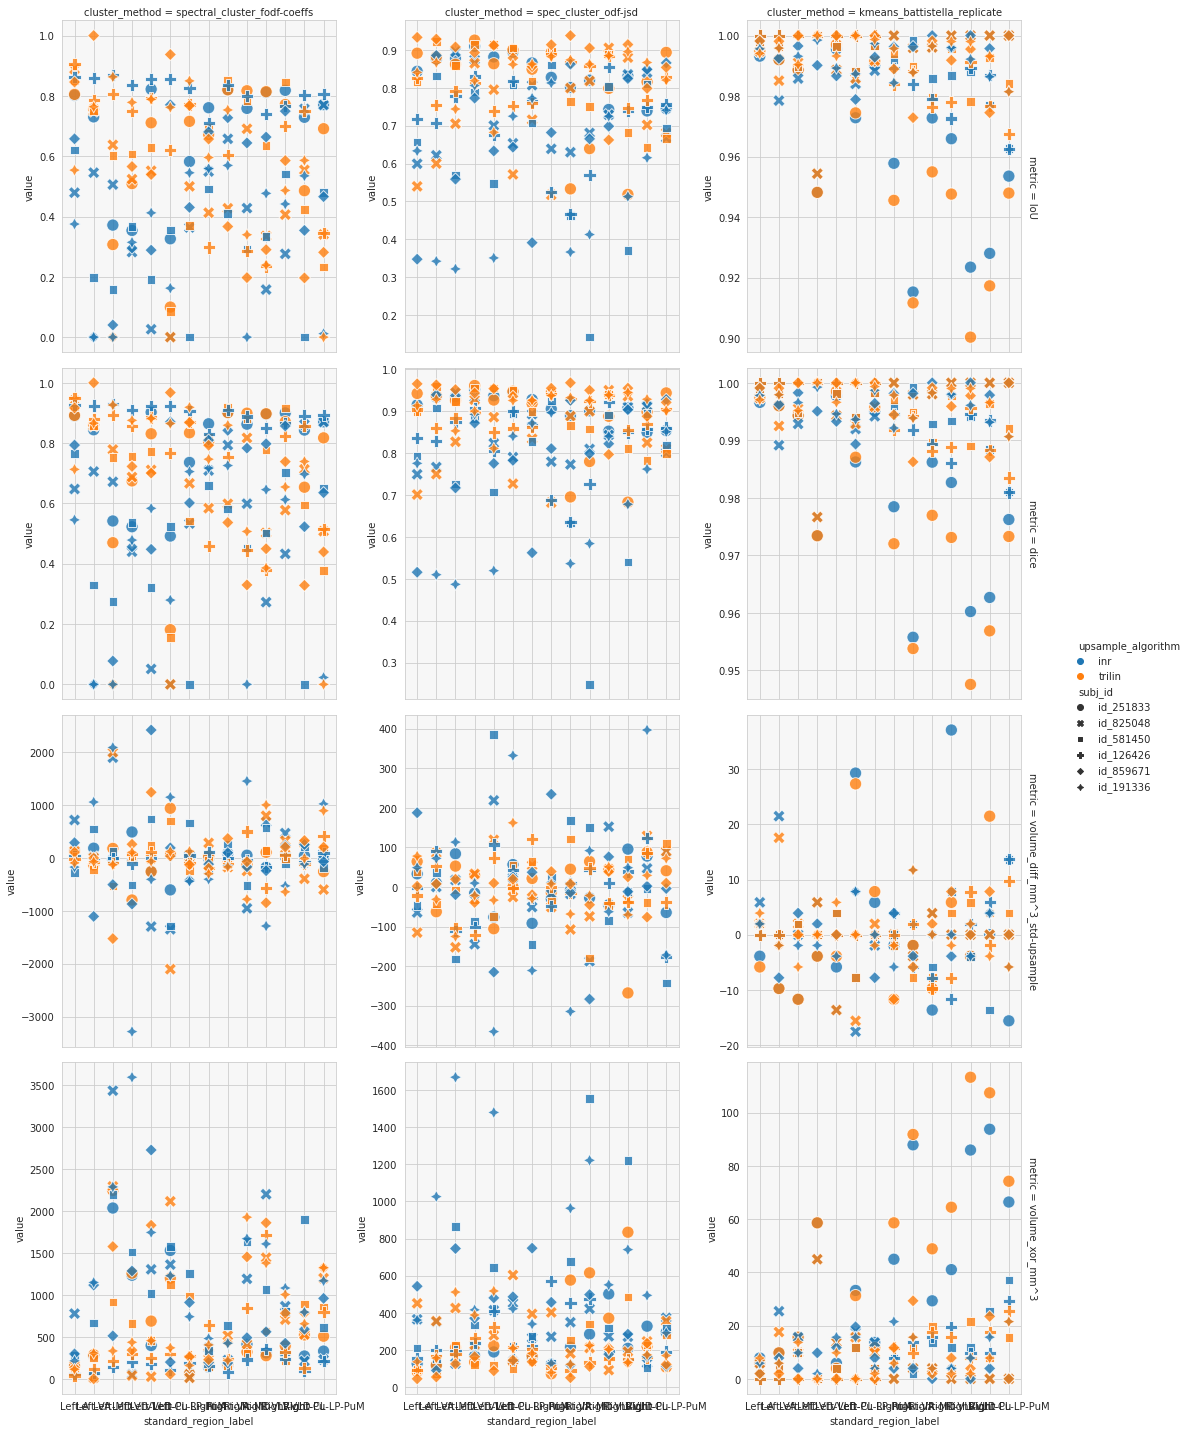

In [90]:
with sns.axes_style("whitegrid", {"axes.facecolor": "0.97"}):
    plt.figure(dpi=150)
    sns.relplot(
        compare_tables,
        x="standard_region_label",
        y="value",
        hue="upsample_algorithm",
        style="subj_id",
        col="cluster_method",
        row="metric",
        kind="scatter",
        facet_kws={"sharey": False, "margin_titles": True, "despine": False},
        s=150.0,
        alpha=0.8,
        edgecolors=None,
        linewidths=0,
    )

<Figure size 1200x800 with 0 Axes>

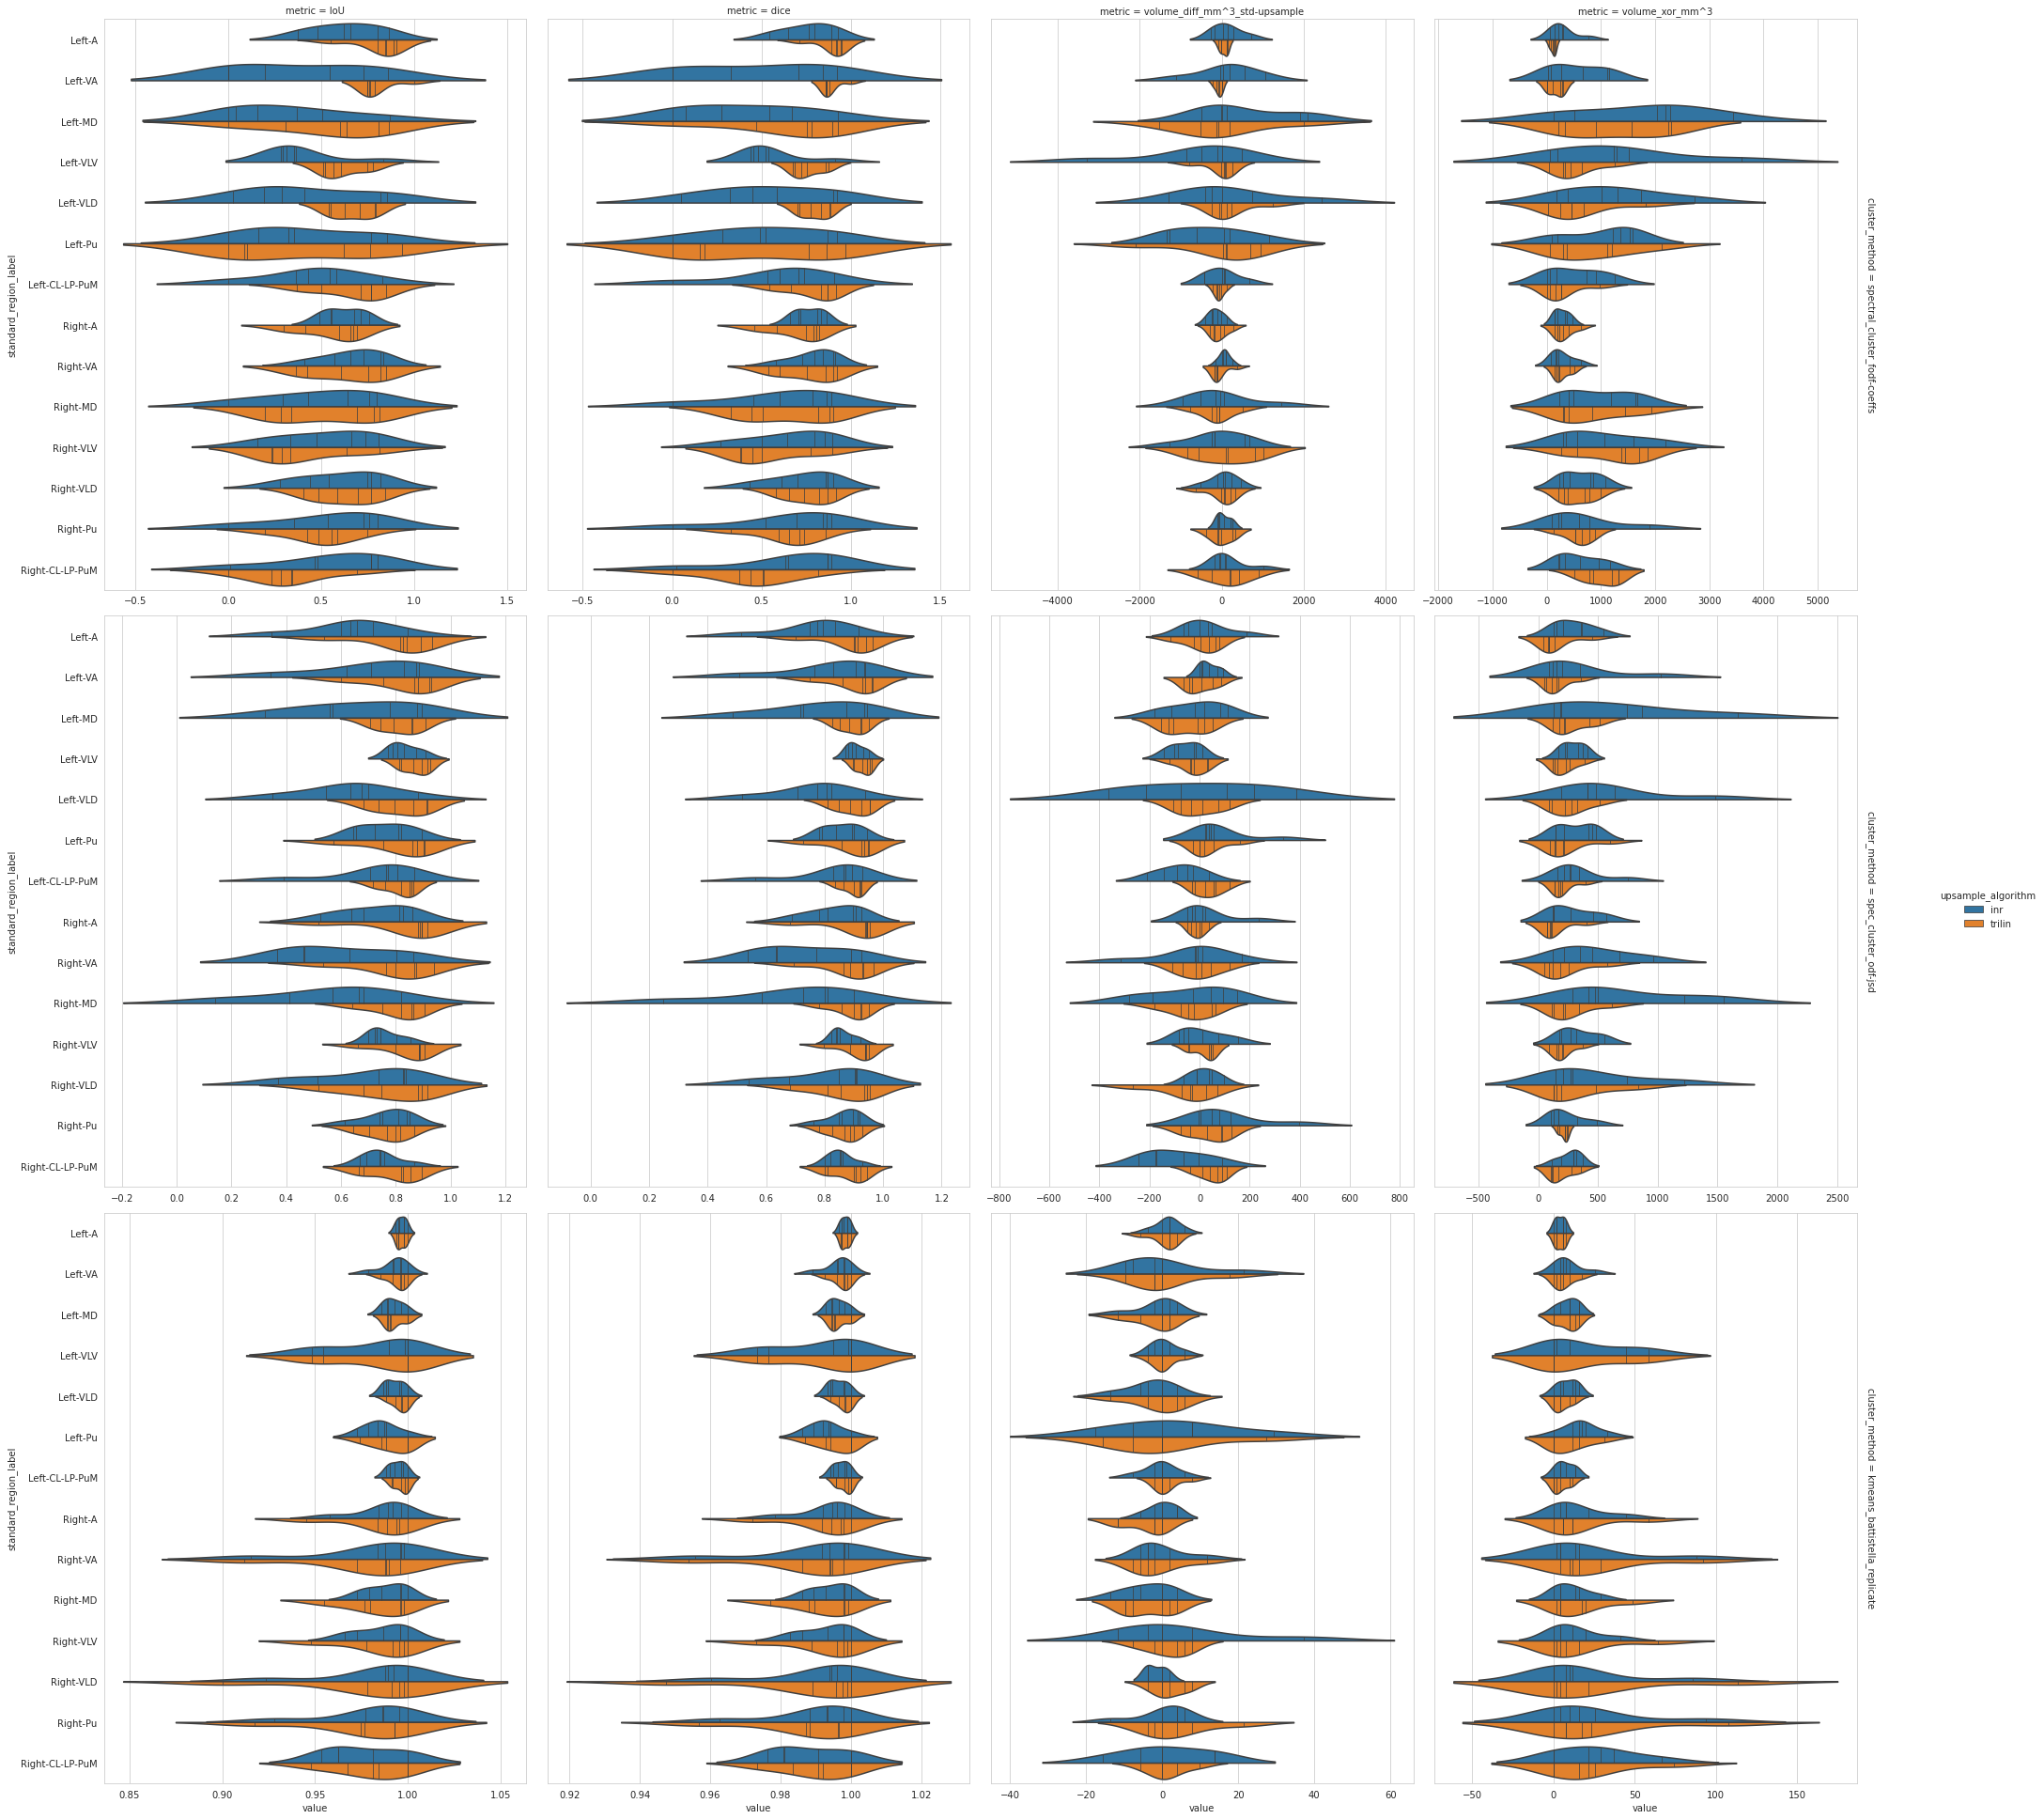

In [110]:
with sns.axes_style("whitegrid"):
    plt.figure(dpi=200)
    sns.catplot(
        compare_tables,
        x="value",
        y="standard_region_label",
        hue="upsample_algorithm",
        row="cluster_method",
        col="metric",
        kind="violin",
        height=9,
        aspect=0.8,
        sharex=False,
        margin_titles=True,
        facet_kws={"margin_titles": True, "despine": False},
        split=True,
        # cut=0.5,
        inner="stick",
        scale="width",
        # s=150.0,
        # alpha=0.8,
        # edgecolors=None,
        # linewidths=0,
    )

---

/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


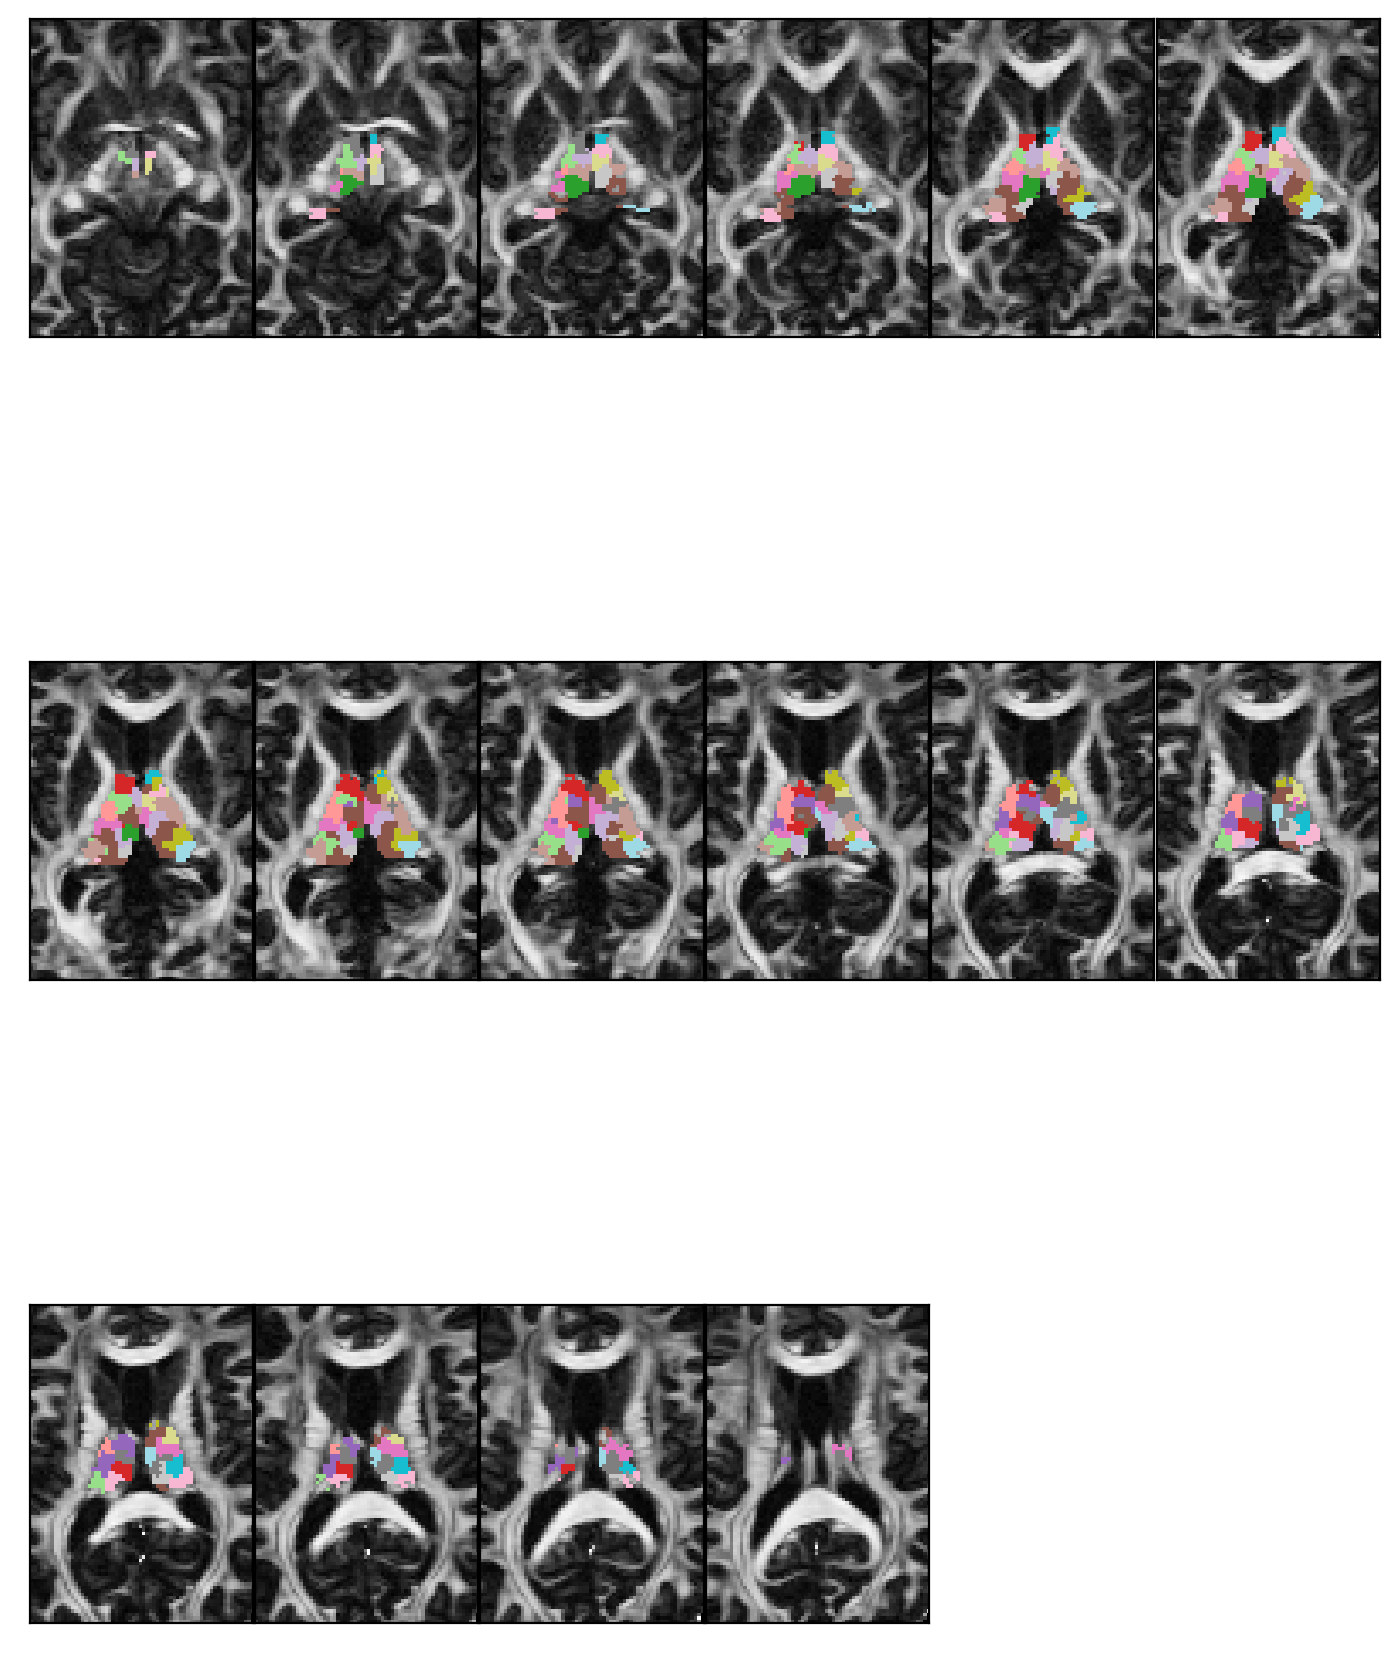

In [33]:
# Clustering 23 nuclei, like freesurfer?
d = copy.deepcopy(subj_data["126426"])

seg_out = np.zeros_like(d.fa)
for side in ("l", "r"):
    coord_feats = d[f"{side}_coords"]
    fodf_feats = d[f"{side}_wm_fodf_coeffs"]
    feats = np.concatenate([coord_feats, fodf_feats], axis=1)

    connectivity_mask = np.zeros_like(d.fa).astype(bool)
    connectivity_mask[d[f"{side}_thal_idx"]] = True
    connectivity = sklearn.feature_extraction.image.grid_to_graph(
        *seg_out.shape, mask=connectivity_mask
    )

    agg_cluster = sklearn.cluster.AgglomerativeClustering(
        n_clusters=23, affinity="euclidean", connectivity=connectivity, linkage="ward"
    )
    pred_labels = agg_cluster.fit_predict(feats)

    if side == "l":
        pred_labels = pred_labels + left_cluster_idx_add
    elif side == "r":
        pred_labels = pred_labels + right_cluster_idx_add

    seg_out[d[f"{side}_thal_idx"]] = pred_labels

seg_plotter(d.fa, seg_out)
del d

In [40]:
subj_data["126426"].keys()

dict_keys(['subj_id', 'out_dir', 'wm_fodf_f', 'aseg_f', 'fa_f', 'fs_thal_seg_f', 'pred_results_dir', 'pred_fodf_inr_f', 'pred_fodf_trilin_f', 'wm_fodf_im', 'aseg_im', 'fa_im', 'fs_thal_seg_im', 'pred_fodf_inr_im', 'pred_fodf_trilin_im', 'fa', 'aseg', 'l_thal_mask', 'r_thal_mask', 'l_thal_idx', 'r_thal_idx', 'l_wm_fodf_coeffs', 'l_coords', 'l_pred_fodf_coeffs_inr', 'l_pred_fodf_coeffs_trilin', 'r_wm_fodf_coeffs', 'r_coords', 'r_pred_fodf_coeffs_inr', 'r_pred_fodf_coeffs_trilin', 'batt_labels_from_fs_f', 'batt_replicate_seg_f', 'spectral_jsd_seg_f', 'spectral_odf_coeff_seg_f'])

In [52]:
feats.shape

(2959, 48)

[0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


/opt/mambaforge/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


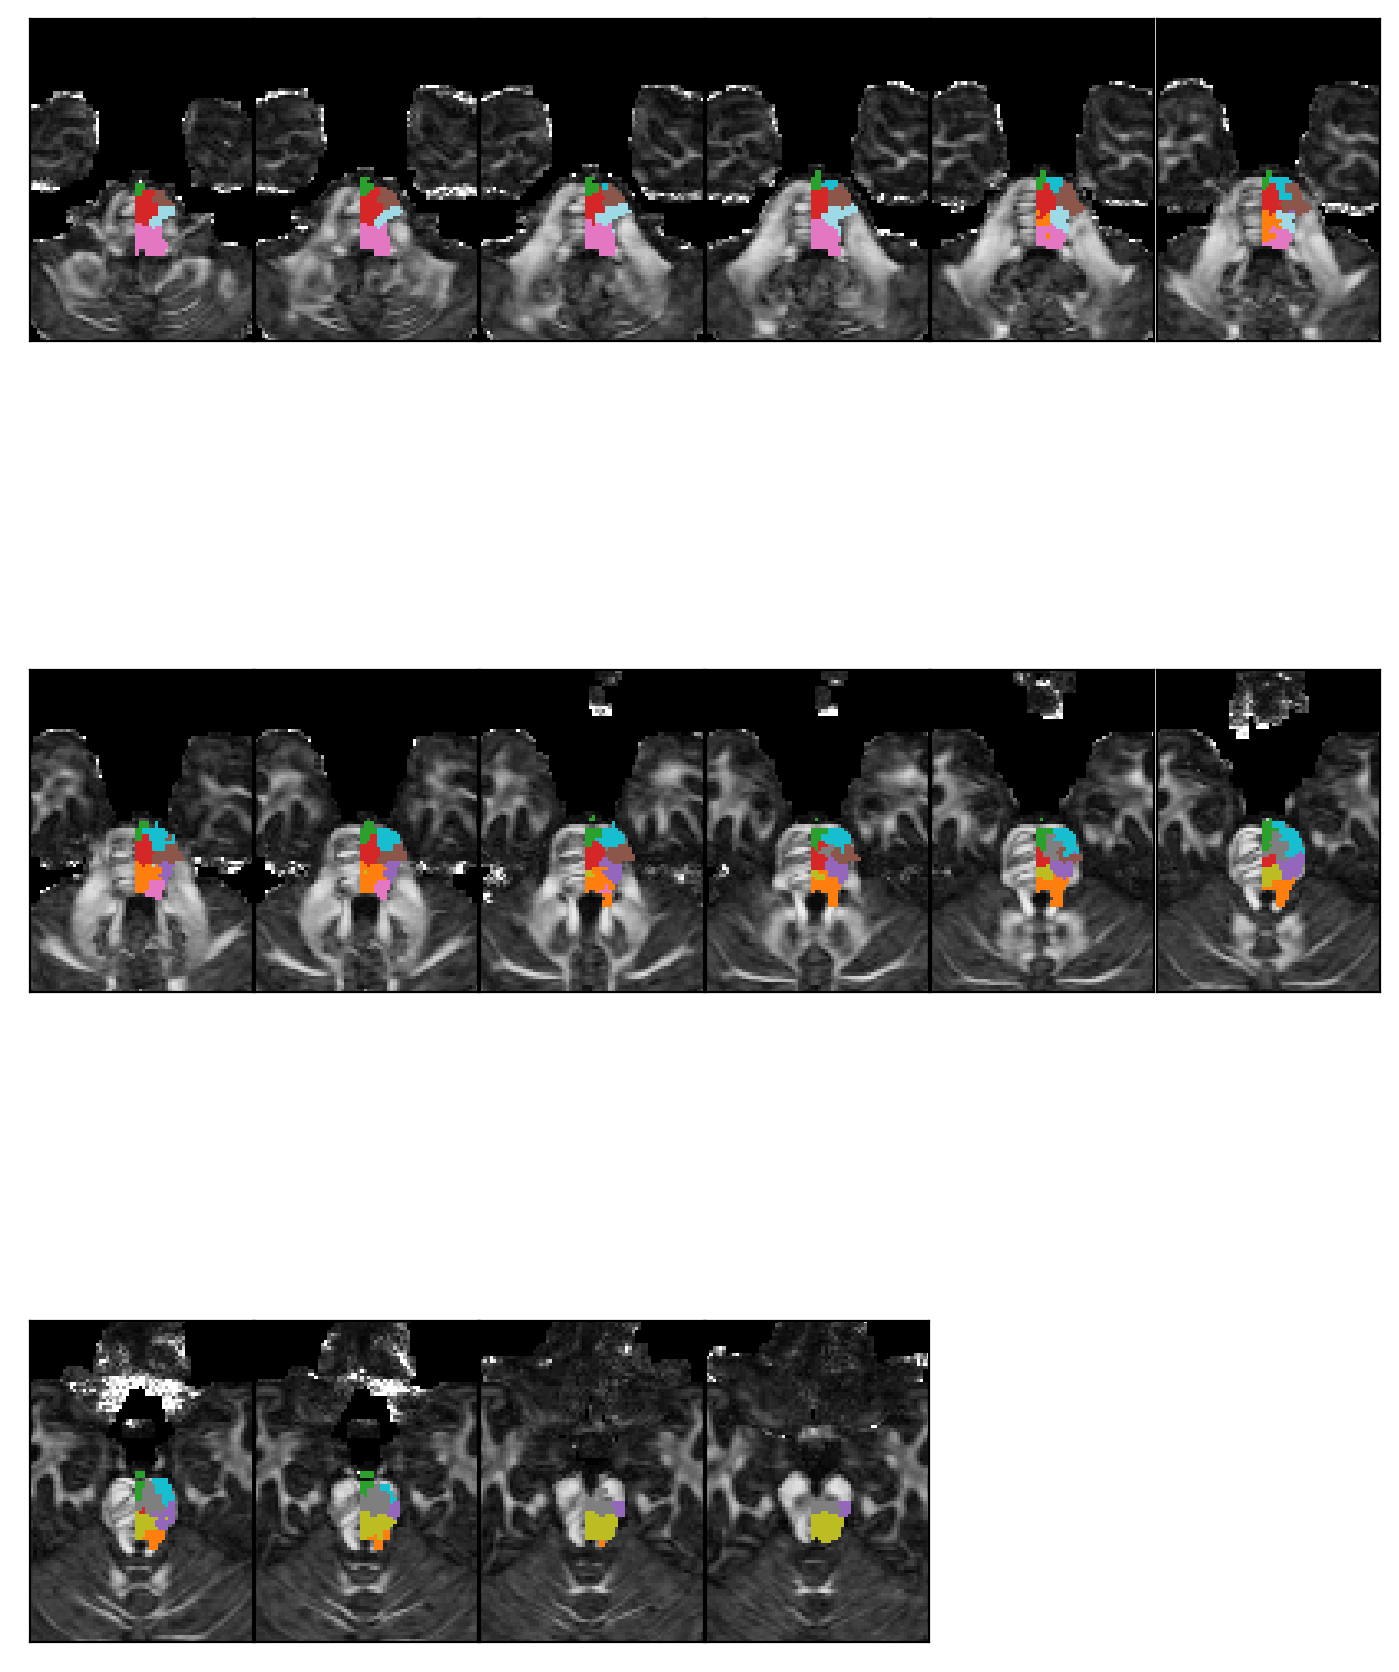

In [15]:
# Brainstem clustering
d = copy.deepcopy(subj_data["825048"])
seg_out = np.zeros_like(d.fa)

aparc = d.aseg_im.get_fdata(caching="unchanged").astype(int)
brainstem_mask = aparc == 16
axial_select = np.zeros_like(brainstem_mask)
# only take axial slices 23 - 39
axial_select[:, :, 23:40] = True
brainstem_mask = brainstem_mask & axial_select
# only take the left side
side_select = np.zeros_like(axial_select)
side_select[52:, :, :] = True
brainstem_mask = brainstem_mask & side_select

coords = pitn.affine.affine_coordinate_grid(
    torch.from_numpy(d.fa_im.affine), d.fa.shape
)
coords = coords.to(torch.float32).cpu().numpy()
coord_feats = coords[brainstem_mask]
wm_fodf_coeffs = d.wm_fodf_im.get_fdata(caching="unchanged").astype(np.float32)
fodf_feats = wm_fodf_coeffs[brainstem_mask]

feats = np.concatenate([coord_feats, fodf_feats], axis=1)

connectivity = sklearn.feature_extraction.image.grid_to_graph(
    *seg_out.shape, mask=brainstem_mask
)

birch_cluster = sklearn.cluster.Birch(n_clusters=10, compute_labels=True)
pred_labels = birch_cluster.fit_predict(feats)
# agg_cluster = sklearn.cluster.AgglomerativeClustering(
#     n_clusters=10, affinity="euclidean", connectivity=connectivity, linkage="ward"
# )
# pred_labels = agg_cluster.fit_predict(feats)

print(np.unique(pred_labels))
pred_labels = pred_labels + 1
print(np.unique(pred_labels))
seg_out[brainstem_mask] = pred_labels

seg_plotter(d.fa, seg_out)
del d